In [1]:
import pickle
import json
import collections
import random
import os
import io
import requests
import powerlaw
import wordcloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import torch

from scipy import stats
from scipy.stats import quantile
from collections import Counter, defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from embed_articles import embed_articles
from cosine_similarity import cosine_sim
from get_data import get_new_articles
from sentiments import sentiment_scores

# !!!! If you are not using environment from conda_environment.yml file in git repo, then make sure to first run this for pip users:
# > pip install spacy
# > python -m spacy download en_core_web_sm
# or for conda users
# > conda install -c conda-forge spacy
# > conda install -c conda-forge spacy-model-en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

c:\Users\bella\miniconda3\envs\02805SGI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting Notebook Parameters

In [3]:
data_filename = 'newsdata.json'
embeddings_filename = 'embedded_articles.pkl'
cossim_desc_filename = 'cosine_similiarties_descriptions.pkl'
cossim_title_filename = 'cosine_similiarties_titles.pkl'
embedding_variables = ['description', 'title']
run_embedding = False   # True if no local file with embeddings
run_cossim = False      # True if no local file with cosine similiarities
save_results = False    # If True, then the embeddings and cossims are saved to a file after they are run
run_new_pos = False     # True if no local file with newest position

get_new_nodes = False # Set to true if you want to use api credits to get more data

create_new_graph = False # True if you want to create a new graph with your embeddings. False to load in existing from .gml file
save_new_graph = False # True to save your new graph

create_new_sentiments = False # True if you want to calculate the sentiment and emotional profiles again

## Creating Dataset

#### **Get new articles**

In [4]:
# Run to use up to 30 newsdata.io credits for more articles
if get_new_nodes:
    william, bella, nicolai = "Api keys aren't here anymore :("
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles before: {len(json.load(f))-1}')
    try:
        get_new_articles(api_key=nicolai, data_filename=data_filename, verbose=False)
    except Exception as e:
        print('No more api credits')
    with open('newsdata.json', 'r') as f:
        print(f'Number of articles after: {len(json.load(f))-1}')

#### **Get embeddings and cosine similarities**

In [5]:
if run_embedding:
    # Embedding all articles
    print('Running embedding')
    embedded_articles, embedding_length, num_articles = embed_articles(input_filename=data_filename, 
                                                                    embedding_variables=embedding_variables) 
    print("Size of each embedding:", embedding_length)
    print("Amount of articles reviewed:", num_articles)
    print("Amount of articles embedded:", len(embedded_articles))
    print("Finished running embedding")
    
    if save_results:
        print("Saving embeddings to file")
        with open(embeddings_filename, 'wb') as f:
            pickle.dump(embedded_articles, f)
else:
    with open(embeddings_filename, 'rb') as f:
        embedded_articles = pickle.load(f)

if run_cossim:
    # Calculating cosine similarity on titles and descriptions
    print()
    print("Running cosine similarity")
    emb_titles = []
    emb_desc = []
    for key in embedded_articles.keys():
        emb_titles.append(embedded_articles[key]['embedded_title'])
        emb_desc.append(embedded_articles[key]['embedded_description'])
    print("Running cosine similarities for titles")
    cossim_titles = cosine_sim(input_data=emb_titles)
    print("Running cosine similarities for descriptions")
    cossim_desc = cosine_sim(input_data=emb_desc)
        
    print("Finished running cosine similarity")
    
    if save_results:
        print("Saving cossims to file")
        with open(cossim_title_filename, 'wb') as f:
            pickle.dump(cossim_titles, f)
        with open(cossim_desc_filename, 'wb') as f:
            pickle.dump(cossim_desc, f)
else:
    with open(cossim_desc_filename, 'rb') as f:
        cossim_desc = pickle.load(f)
    with open(cossim_title_filename, 'rb') as f:
        cossim_titles = pickle.load(f)

## Extracting attributes for creating graph

In [6]:
# Getting articles without embeddings for creating attributes for nx graph
print('Extracting articles without embeddings')
all_articles = {}
for id, article in embedded_articles.items():
    article_no_embedding = article
    for var in embedding_variables:
        article_no_embedding.pop(f'embedded_{var}')
    all_articles[id] = article_no_embedding

Extracting articles without embeddings


### Getting press freedom and corruption data

In [7]:
## Turning graph into dataframe 
# Turning articles id's into node attributes
# Changing country from list to string
nwdf_init = pd.DataFrame.from_dict(all_articles, orient='index')
nwdf_init.index.name = 'article id'
nwdf_init = nwdf_init.reset_index()
nwdf_init['country'] = nwdf_init['country'].str[0]

## Adding press freedom index data

pressfreedom = pd.read_csv('RWB_PFI_WIDEF.csv') 

# Removing non-informative attributes
non_informative_att = []
for attribute in pressfreedom.keys():
    if len(pressfreedom[attribute].unique()) < 2:
        non_informative_att.append(attribute)
pressfreedom = pressfreedom.drop(columns=non_informative_att, axis=1)
pressfreedom = pressfreedom.drop(columns=['REF_AREA', 'UNIT_TYPE', 'INDICATOR', 'UNIT_MEASURE', 'UNIT_TYPE_LABEL', 'UNIT_MEASURE_LABEL'], axis=1)

# Cleaning country names and indicator labels
names = {'Viet Nam': 'Vietnam', 'Venezuela, RB': 'Venezuela', 'Russian Federation': 'Russia', 
         'Kyrgyz Republic': 'Kyrgyzstan', 'Hong Kong SAR, China': 'Hong Kong', 
         'United States': 'United States of America', 'Syrian Arab Republic': 'Syria', 
         'Iran, Islamic Rep.': 'Iran', 'Netherlands': 'Netherland', 'Korea, Rep.': 'South Korea'}

labels = {'sociocultural context': 'sociocultural context score',
 'safety': 'safety score',
 'legal framework': 'legal framework score',
 'political context': 'political context score',
 'economic context': 'economic context score'}

pressfreedom['REF_AREA_LABEL'] = (pressfreedom['REF_AREA_LABEL'].replace(names)) # Correcting country names
pressfreedom['REF_AREA_LABEL'] = pressfreedom['REF_AREA_LABEL'].str.lower() # Lowercase country names
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.lower() # Lowercase indicator labels
pressfreedom['INDICATOR_LABEL'] = pressfreedom['INDICATOR_LABEL'].str.removeprefix('press freedom index: ') # Removing prefix
pressfreedom['INDICATOR_LABEL'] = (pressfreedom['INDICATOR_LABEL'].replace(labels)) # Renaming some indicators to include that they are scores

# Getting list of countries in the network
countries = []
for article_id, article_attrs in all_articles.items():
    if article_attrs['country'][0] not in countries:
        countries.append(article_attrs['country'][0])
countries = set(countries)

# Removing non-countries
countries.remove('world')
countries.remove('solomon islands')

# Attaching press freedom data to countries in the network
x = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
indicators = list(pressfreedom['INDICATOR_LABEL'].unique())
indicators.remove('press freedom index rank')

country_data_pf = {}
for country in countries:
    if country in pressfreedom['REF_AREA_LABEL'].values: # Only include countries with press freedom data
        # Getting press freedom ranks over time for country
        mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
        (pressfreedom['INDICATOR_LABEL'] == 'press freedom index rank'))
        out = pressfreedom.loc[mask, '2002':'2025'].values[0]
        new_out = []
        new_x = []
        for i in range(len(out)):
            if out[i] == 'nan' or np.isnan(out[i]):
                continue
            else:
                new_out.append(out[i])
                new_x.append(x[i])
        # Get statistics of press freedom ranks
        mean, minrank, maxrank, median, variance, slope = round(np.mean(new_out),2), np.min(new_out), np.max(new_out), np.median(new_out), round(np.var(new_out),2), stats.linregress(new_x,list(new_out))[0]
        country_data_pf[country] = {'press freedom current rank': new_out[-1], 
                                                            'press freedom slope of ranks': slope, 'press freedom mean rank': mean, 
                                                            'press freedom median rank': median, 'press freedom variance': variance, 
                                                            'press freedom min rank': minrank, 'press freedom max rank': maxrank}
        # Getting other indicators for the country for 2025
        for indicator in indicators:
            mask = ((pressfreedom['REF_AREA_LABEL'] == country) &
            (pressfreedom['INDICATOR_LABEL'] == indicator))
            out = pressfreedom.loc[mask, '2025'].values[0]
            country_data_pf[country][indicator] = out  
# Creating dataframe
pressfreedompd = pd.DataFrame.from_dict(country_data_pf, orient='index').reset_index().rename(columns={'index': 'country'})

## Adding corruption perception index data
# 'Entity' is the country name column
# 'World regions according to OWID' is the continent column
corruption = pd.read_csv('ti-corruption-perception-index.csv')
corruption['Entity'] = corruption['Entity'].str.lower()
corruption['World regions according to OWID'] = corruption['World regions according to OWID'].str.lower()

# Cleaning country names
names = {'united states': 'united states of america', 'netherlands': 'netherland'}
corruption['Entity'] = (corruption['Entity'].replace(names))

# Creating dictionary of continents and their countries
conts_dict = {cont: [] for cont in corruption['World regions according to OWID'].unique()[1:]} # Skipping first value which is NaN
for cont in corruption['World regions according to OWID'].unique()[1:]: 
        mask = ((corruption['World regions according to OWID'] == cont))
        out = corruption.loc[mask, 'Entity'].values
        conts_dict[cont] = out

# Getting list of corruption countries that are also in our dataset
cor_countries = []
for country in list(corruption['Entity'].unique()):
    if country in countries:
        cor_countries.append(country)
cor_countries = set(cor_countries)

corruption_dict = {country: {} for country in countries}
for country in countries:
    if country in corruption['Entity'].values: # Only include countries with corruption data
        years = corruption.loc[((corruption['Entity'] == country)), 'Year'].values
        x = []
        y = []
        for year in years:
            # Getting corruption scores over time for country
            mask = ((corruption['Entity'] == country) &
                    (corruption['Year'] == year))
            if np.isnan(corruption.loc[mask, 'Corruption Perceptions Index'].values[0]):
                print(f"{country} has nan-value in {year}. Did not include")
            else:
                x.append(year)
                y.append(corruption.loc[mask, 'Corruption Perceptions Index'].values[0])
        if len(y) > 0:
            mean, minrank, maxrank, median, variance = round(np.mean(y),2), np.min(y), np.max(y), np.median(y), round(np.var(y),2)
            if len(y) >= 2:
                slope = stats.linregress(x, y).slope
            else:
                slope = 0
            corruption_dict[country] = {'corruption latest score': y[-1], 'corruption score slope': slope, 'corruption mean score': mean, 'corruption median score': median, 'corruption score variance': variance, 'corruption min score': minrank, 'corruption max score': maxrank}
    for cont in conts_dict:
        if country in conts_dict[cont]:
            corruption_dict[country]['continent'] = cont
# Adding corruption data to dataframe
corruptpd = pd.DataFrame.from_dict(corruption_dict, orient='index').reset_index().rename(columns={'index': 'country'})

# Adding both as attributes in the network
nwdf_pf = pd.merge(nwdf_init,pressfreedompd, on="country", how="left")
nwdf_pf_co = pd.merge(nwdf_pf,corruptpd, on="country", how="left")

# Cleaning netherland name in nwdf
for country in nwdf_pf_co['country']: 
    if country == 'netherland':
        nwdf_pf_co.loc[nwdf_pf_co['country'] == country, 'country'] = 'netherlands'

belize has nan-value in 2023. Did not include


#### Example dataframe with press freedom data

In [8]:
country_counts = Counter([all_articles[article_id]["country"][0] for article_id in all_articles.keys()])
country_counts_pd = pd.DataFrame(list(country_counts.items()), columns=["country", "count"])

coruption_data = {country: corruption_dict[country] for country in corruption_dict if len(list(corruption_dict[country])) > 1}
combined_data = {}
for country in country_data_pf.keys():
    combined_data[country] = {
        'press freedom current rank': country_data_pf[country]['press freedom current rank'],
        'press freedom slope of ranks': round(country_data_pf[country]['press freedom slope of ranks'], 2),
        'corruption latest score': coruption_data[country]['corruption latest score'] if country in coruption_data else None,
        'corruption score slope': round(coruption_data[country]['corruption score slope'], 2) if country in coruption_data else None
    }
combined_data_df = pd.DataFrame.from_dict(combined_data, orient='index').reset_index().rename(columns={'index': 'country'})
df = pd.merge(country_counts_pd,combined_data_df[["country", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country", how="left")
df.head()

country  count  press freedom current rank  \
0                 australia    371                        29.0   
1            united kingdom    378                        20.0   
2  united states of america   2622                        57.0   
3                    canada    392                        21.0   
4               south korea     21                        61.0   

   press freedom slope of ranks  corruption latest score  \
0                         -0.09                     77.0   
1                          0.24                     71.0   
2                          1.41                     65.0   
3                          0.14                     75.0   
4                          0.49                     64.0   

   corruption score slope  
0                   -0.66  
1                   -0.47  
2                   -0.74  
3                   -0.82  
4                    0.91

### Adding more data to df and nwdf using naturalearth database

The DataFrame **world** below here is downloaded from natural earths geo data sets in size $1:110m$ and has a lot of information. We use the following subset. All information is descriped in world_data_set_description.ipynb


- **POP_EST**
- - Estimated population
- **POP_YEAR**
- - Year the estimated population is taken
- **GDP_MD**
- - Gross Domestic Product in millions of dollars (MD)
- **GDP_YEAR**
- - Year the Gross Domestic Product is taken.
- **INCOME_GRP**
- - One of these groups: *'1. High income: OECD', '2. High income: nonOECD', '3. Upper middle income', '4. Lower middle income', '5. Low income'*
- **geometry**
- - The geometry of the country. Either in Multipolygon or Polygon.

In [9]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

world = world.rename(columns={"ADMIN": "country"})
world = world[world["country"] != "Antarctica"]
world = world.to_crs("EPSG:4087")
world["country_norm"] = world["country"].str.lower().str.strip()

df_fixed = df.copy()
df_fixed["country"] = df_fixed["country"].str.strip().str.lower()

name_fix = {
    "netherland": "netherlands",
}
df_fixed["country"] = df_fixed["country"].replace(name_fix)
df_fixed["country_norm"] = df_fixed["country"]

gdf = world.merge(df_fixed[["country_norm", "count", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country_norm", how="inner")
gdf["articles_per_million"] = round((gdf["count"] / gdf["POP_EST"]) * 10e6 , 2)
keep = ['country_norm', 'POP_EST', 'GDP_MD', 'INCOME_GRP', 'count', 'articles_per_million', 'geometry', "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']
gdf = gdf[keep]
gdf.rename(columns={"country_norm": "country", "POP_EST": "population", 'GDP_MD': "gross domestic product (millions usd)", "INCOME_GRP": "income group", "count": "number of articles", "articles_per_million": "articles per million capita"}, inplace=True)
nwdf_ne = pd.merge(nwdf_pf_co,gdf[['country', 'population', 'gross domestic product (millions usd)', 'income group', 'number of articles', 'articles per million capita']], on='country', how='left')

### Data from Our world in data

In [10]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"
}

# https://ourworldindata.org/grapher/gdp-per-capita-worldbank
url_gdp_capita = "https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?v=1&csvType=full&useColumnShortNames=true"

# https://ourworldindata.org/grapher/inflation-of-consumer-prices?overlay=download-data
url_inflation = "https://ourworldindata.org/grapher/inflation-of-consumer-prices.csv?v=1&csvType=full&useColumnShortNames=true" 

# https://ourworldindata.org/grapher/consumer-price-index
url_consumer_price_index = "https://ourworldindata.org/grapher/consumer-price-index.csv?v=1&csvType=full&useColumnShortNames=true"


# https://ourworldindata.org/grapher/median-age?overlay=download-data
url_median_age = "https://ourworldindata.org/grapher/median-age.csv?v=1&csvType=full&useColumnShortNames=true"

#https://ourworldindata.org/grapher/average-years-of-schooling?overlay=download-data
url_average_schooling_years = "https://ourworldindata.org/grapher/average-years-of-schooling.csv?v=1&csvType=full&useColumnShortNames=true"

In [11]:
r = requests.get(url_gdp_capita, headers=headers)
r.raise_for_status()
gdp_capita = pd.read_csv(io.StringIO(r.text))
gdp_capita = gdp_capita[(gdp_capita.Year == 2024)][['Entity', 'ny_gdp_pcap_pp_kd']]
gdp_capita.rename(columns={'Entity': 'country', 'ny_gdp_pcap_pp_kd': 'gdp per capita 2024 international dollars'}, inplace=True)
gdp_capita['country'] = gdp_capita['country'].str.lower()

r = requests.get(url_inflation, headers=headers)
r.raise_for_status()
inflation = pd.read_csv(io.StringIO(r.text))
inflation = inflation[inflation.Year == 2024][['Entity', 'fp_cpi_totl_zg']]
inflation.rename(columns={'Entity': 'country', 'fp_cpi_totl_zg': 'inflation 2024 percent change'}, inplace=True)
inflation['country'] = inflation['country'].str.lower()

r = requests.get(url_consumer_price_index, headers=headers)
r.raise_for_status()
consumer_price_index = pd.read_csv(io.StringIO(r.text))
consumer_price_index = consumer_price_index[consumer_price_index.Year == 2024]
consumer_price_index.rename(columns={'Entity': 'country', 'fp_cpi_totl': 'consumer price index in 2024 compared to 2010'}, inplace=True)
consumer_price_index['country'] = consumer_price_index['country'].str.lower()
consumer_price_index = consumer_price_index[['country', 'consumer price index in 2024 compared to 2010']]

r = requests.get(url_median_age, headers=headers)
r.raise_for_status()
median_age = pd.read_csv(io.StringIO(r.text))
median_age = median_age[median_age.Year == 2024]
median_age = median_age[['Entity', 'median_age__sex_all__age_all__variant_medium']]
median_age.rename(columns={'Entity': 'country', 'median_age__sex_all__age_all__variant_medium': 'median age 2024'}, inplace=True)
median_age['country'] = median_age['country'].str.lower()

r = requests.get(url_average_schooling_years, headers=headers)
r.raise_for_status()
school_years = pd.read_csv(io.StringIO(r.text))
school_years = school_years[school_years.Year == 2023]
school_years.rename(columns={'Entity': 'country', 'mys__sex_total': 'average years of schooling 2023'}, inplace=True)
school_years['country'] = school_years['country'].str.lower()
school_years = school_years[['country', 'average years of schooling 2023']]

nwdf_owid = pd.merge(nwdf_ne,gdp_capita, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,inflation, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,consumer_price_index, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,median_age, on='country', how='left')
nwdf_owid = pd.merge(nwdf_owid,school_years, on='country', how='left')

### Adding sentiment score to dataframe

In [12]:
if create_new_sentiments:
    sentiment_scores()

with open('sentiments_description.json', 'r') as f:
    sentiments_description = json.load(f)
with open('sentiments_title.json', 'r') as f:
    sentiments_title = json.load(f)
with open('articles_description_emotions.json', 'r') as f:
    emotions_description = json.load(f)
with open('articles_title_emotions.json', 'r') as f:
    emotions_title = json.load(f)
with open('wl_description.json', 'r') as f:
    wl_description = json.load(f)
with open('wl_title.json', 'r') as f:
    wl_title = json.load(f)

sentimentd = pd.DataFrame.from_dict(sentiments_description, orient='index')
sentimentt = pd.DataFrame.from_dict(sentiments_title, orient='index')
emotionsd = pd.DataFrame.from_dict(emotions_description, orient='index')
emotionsd.rename(columns={'anticipation': 'anticipation_d' , 'trust': 'trust_d', 'joy': 'joy_d', 'positive': 'positive_d', 
                          'surprise': 'surprise_d', 'anger': 'anger_d', 'disgust': 'disgust_d', 'negative': 'negative_d', 
                          'fear': 'fear_d', 'sadness': 'sadness_d'}, inplace=True)
emotionst = pd.DataFrame.from_dict(emotions_title, orient='index')

sentimentd.index.name = 'article id'
sentimentt.index.name = 'article id'
emotionsd.index.name = 'article id'
emotionst.index.name = 'article id'

sentimentd.rename(columns={0: 'description_sentiment_score'}, inplace=True)
sentimentt.rename(columns={0: 'title_sentiment_score'}, inplace=True)
emotionsd.rename(columns={0: 'description_emotions_score'}, inplace=True)
emotionst.rename(columns={0: 'title_emotions_score'}, inplace=True)

sentimentpd = pd.concat([sentimentd, sentimentt, emotionsd, emotionst], axis=1)

sentimentpd.reset_index(inplace=True)

wl_title = pd.Series(wl_title)
wl_description = pd.Series(wl_description)

words = pd.DataFrame({'wl_title': wl_title, 'wl_description': wl_description})
words.index.name = 'article id'
words.reset_index(inplace=True)

sentimentpd = sentimentpd.rename(columns = {'article id': 'article id'})
nwdf_sent = pd.merge(nwdf_owid, sentimentpd, on='article id', how='left')
nwdf_sent = pd.merge(nwdf_sent, words, on='article id', how='left')

### **Final dataset**

In [13]:
nwdf = nwdf_sent

## Make index of nwdf the article id again
nwdf = nwdf.set_index('article id')
nwdf.rename(columns={
    'pubDate': 'publication_date'
}, inplace=True)
# Renaming columns to have underscores instead of spaces, as spaces in attribute names won't work for .gml files later
nwdf.rename(columns={
    key: key.replace(' ', '_').replace('(', '').replace(')', '') for key in nwdf.columns
}, inplace=True)
nwdf.reset_index(inplace=True)
nwdf.to_pickle('nwdf_full.pkl')

## Plotting the dataset

#### **Barplot of the amount of articles per country**

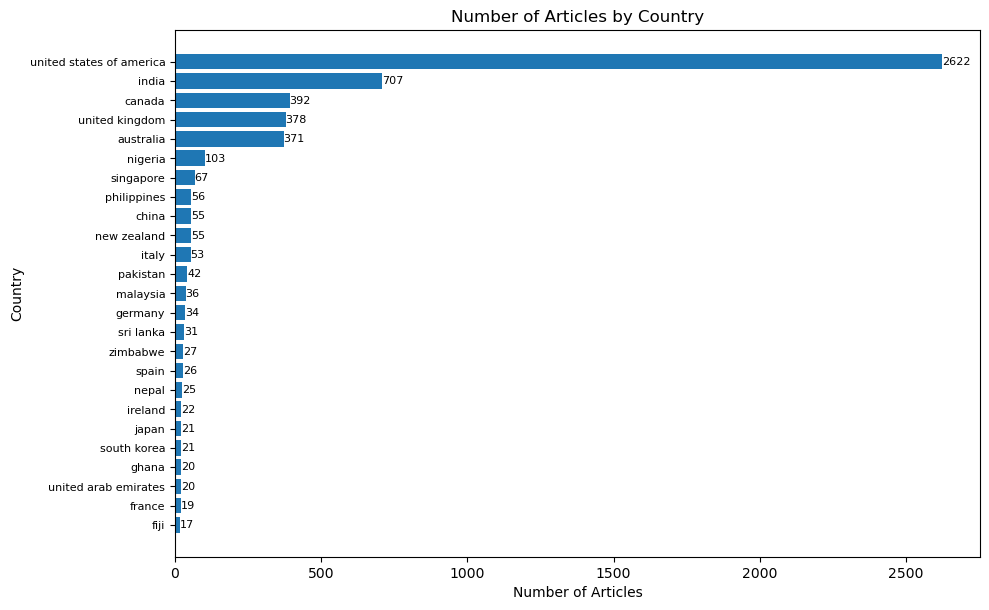

In [14]:
x = []
y = []
for country in sorted(country_counts.items(), key=lambda item: item[1], reverse=False):
    x.append(country[0])
    y.append(country[1])

amount_of_countries = 25
plt.figure(figsize=(10, 6))
plt.barh(x[-amount_of_countries:],y[-amount_of_countries:])
plt.ylabel('Country')
plt.xlabel('Number of Articles')
for _,  out in enumerate(sorted(country_counts.items(), key=lambda item: item[1], reverse=False)[-amount_of_countries:]):
    j = out[0]
    val = out[1]
    plt.text(val, j,
            f"{val:.0f}", va='center',
            ha='left' if val >= 0 else 'right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.title('Number of Articles by Country')
plt.show()

#### **Interactive choropleth map based on articles per million capita**

In [14]:
gdf.explore(column="articles per million capita", legend=True)

## Creating Graph

In [15]:
thres = 0.4
if create_new_graph:
    attr_dict = nwdf.to_dict(orient='index')
    
    G = nx.Graph()
    G.add_nodes_from(list(all_articles.keys()))

    for i in tqdm(range(len(cossim_desc)-1)):
        id_i = list(all_articles.keys())[i]
        for j in range(i+1, len(cossim_desc)):
            id_j = list(all_articles.keys())[j]
            if cossim_desc[i][j] >= thres:
                G.add_edge(id_i, id_j)

    nx.set_node_attributes(G, attr_dict)
    
    if save_new_graph:
        nx.write_gml(G, f'nx_graph_{thres}.gml')
else:
    G = nx.read_gml(f'nx_graph_{thres}.gml')

### Nodes and edges

In [16]:
H = G.subgraph(max(nx.connected_components(G), key=len))
print("Number of nodes in largest connected component:", H.number_of_nodes())
print("Number of edges in largest connected component:", H.number_of_edges())
print("Node attributes are:", list(list(H.nodes(data=True))[0][1].keys()))
print(f"{round(len(H.nodes())/len(G.nodes())*100,2)}% of the nodes are in the largest connected component.")
print(f"{round(len(H.edges())/len(G.edges())*100,2)}% of the nodes are in the largest connected component.")

Number of nodes in largest connected component: 4446
Number of edges in largest connected component: 30353
Node attributes are: ['link', 'title', 'description', 'country', 'category', 'publication_date', 'source_id', 'source_name', 'press_freedom_current_rank', 'press_freedom_slope_of_ranks', 'press_freedom_mean_rank', 'press_freedom_median_rank', 'press_freedom_variance', 'press_freedom_min_rank', 'press_freedom_max_rank', 'sociocultural_context_score', 'legal_framework_rank', 'legal_framework_score', 'sociocultural_context_rank', 'safety_score', 'economic_context_score', 'safety_rank', 'political_context_rank', 'press_freedom_index_score', 'political_context_score', 'economic_context_rank', 'corruption_latest_score', 'corruption_score_slope', 'corruption_mean_score', 'corruption_median_score', 'corruption_score_variance', 'corruption_min_score', 'corruption_max_score', 'continent', 'population', 'gross_domestic_product_millions_usd', 'income_group', 'number_of_articles', 'articles_pe

## Plotting the Graph

In [17]:
## Calculating forceatlas2 positions for plotting
if run_new_pos:
    pos = nx.forceatlas2_layout(G, max_iter=1000, scaling_ratio=2, gravity=2, linlog=True, seed=42)
    with open(f'POS_{thres}.pkl', 'wb') as f:    # Saving POS as for later use, as they take time to compute
        pickle.dump(pos, f)
else:
    with open(f'POS_{thres}.pkl', 'rb') as f:    # Loading previously computed POS
        pos = pickle.load(f)

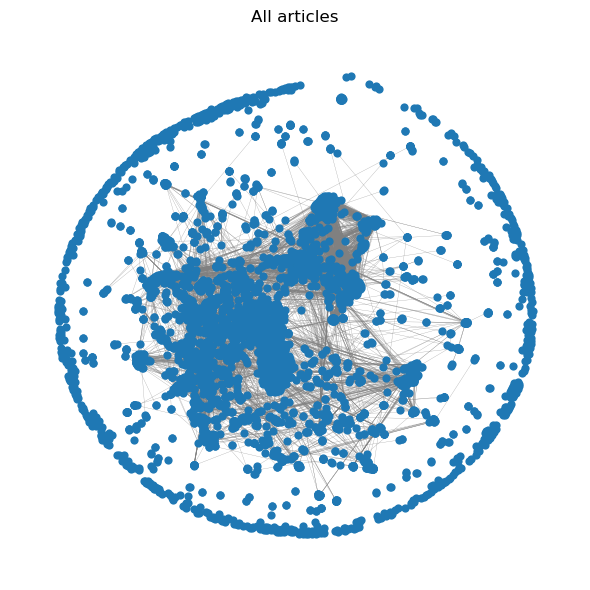

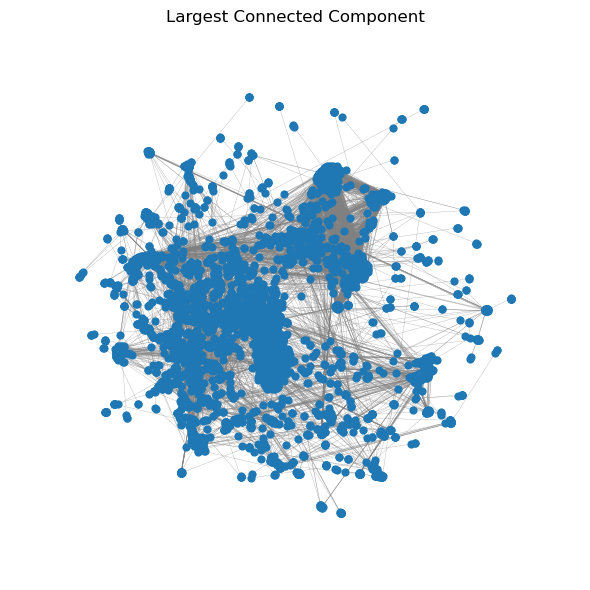

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

nx.draw_networkx_nodes(G, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('All articles')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(6, 6))

nx.draw_networkx_nodes(H, pos, node_size=35, linewidths=0, ax=ax)
nx.draw_networkx_edges(H, pos, width=0.2, alpha=0.8, edge_color="grey", ax=ax)
ax.margins(0.1)
ax.set_axis_off()
ax.set_title('Largest Connected Component')

plt.tight_layout()
plt.show()

## **Network Analysis**

### Network stats

In [27]:
N = H.number_of_nodes()
L = np.sum(list(dict((H.degree)).values()))/2
L_max = N * (N - 1) / 2
avg_degree = 2 * L / N
median_degree = np.median([H.degree(n) for n in H.nodes()])
mode_degree = max(set([H.degree(n) for n in H.nodes()]), key=[H.degree(n) for n in H.nodes()].count)
minimum_degree = min([H.degree(n) for n in H.nodes()])
maximum_degree = max([H.degree(n) for n in H.nodes()])
degree_sequence = sorted((d for n, d in H.degree()), reverse=True)
dmax = max(degree_sequence)
degree_variance = np.var(degree_sequence)
diameter = nx.approximation.diameter(H)
avg_clustering = nx.average_clustering(H)
random = nx.fast_gnp_random_graph(N, p=avg_degree/(N-1), seed=42)
random_avg_clustering = nx.average_clustering(random)
random_shortest = nx.average_shortest_path_length(random)
print("Diameter:", diameter)
print("Average clustering coefficient:", round(avg_clustering,2))
print("Random graph average clustering coefficient:", round(random_avg_clustering,4))
print("Degree Variance:", round(degree_variance,3))
print("Nodes:", int(N))
print("Edges:", int(L))
print("Max possible edges:", int(L_max))
print("Average degree:", round(avg_degree,2))
print("Median degree:", int(median_degree))
print("Mode degree:", int(mode_degree))
print("Minimum degree:", int(minimum_degree))
print("Maximum degree:", int(maximum_degree))
print("Random graph average shortest path length:", round(random_shortest,2))

## Average shortest path length takes upwards of 15 minutes to compute but is 6.04
new_shortest_path_length = False
if new_shortest_path_length:
    avg_shortest_path_length = nx.average_shortest_path_length(H)
else:
    avg_shortest_path_length = 6.04
print("Average shortest path length:", avg_shortest_path_length)

Diameter: 18
Average clustering coefficient: 0.36
Random graph average clustering coefficient: 0.003
Degree Variance: 296.869
Nodes: 4446
Edges: 30353
Max possible edges: 9881235
Average degree: 13.65
Median degree: 7
Mode degree: 2
Minimum degree: 1
Maximum degree: 126
Random graph average shortest path length: 3.51
Average shortest path length: 6.04


### Plotting Degree Distribution

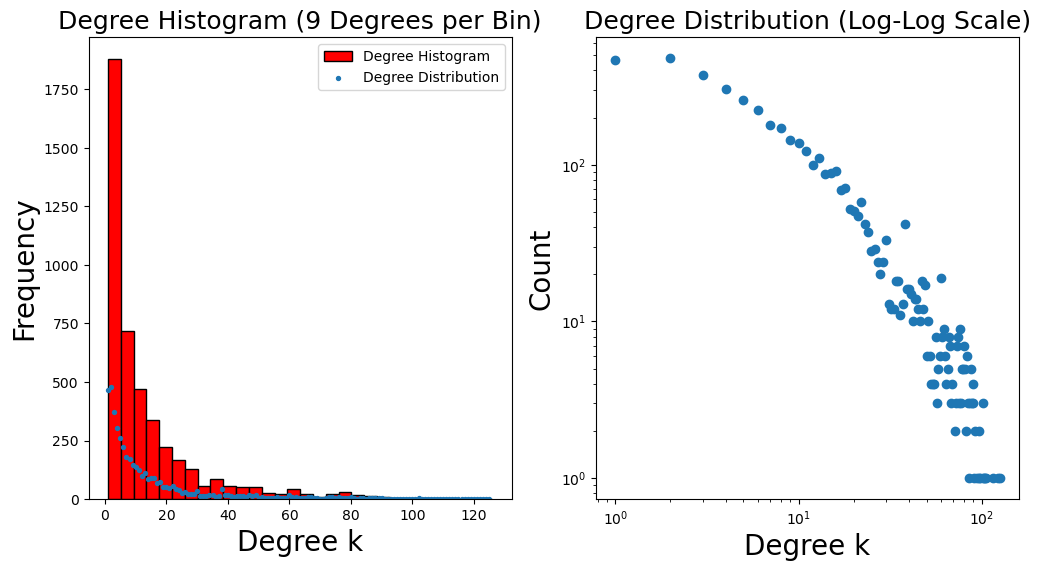

In [28]:
degrees = [H.degree(n) for n in H.nodes()]
k_max = 0
k_min = len(H.edges())
for i in H.nodes():
    if H.degree(i) > k_max:
        k_max = H.degree(i)
    if H.degree(i) < k_min:
        k_min = H.degree(i)

degree_dist = np.histogram([H.degree(i) for i in H.nodes()], bins=range(1, k_max+1))

fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].hist(degrees, bins=30, label='Degree Histogram', color='red', edgecolor='black')
ax[0].scatter(degree_dist[1][:-1],degree_dist[0], s=8, label='Degree Distribution')
ax[0].set_xlabel('Degree k', fontsize=20)
ax[0].set_ylabel('Frequency', fontsize=20)
ax[0].set_title('Degree Histogram (9 Degrees per Bin)', fontsize=18)
ax[0].legend()

ax[1].scatter(degree_dist[1][:-1],degree_dist[0])
ax[1].set_xlabel('Degree k', fontsize=20)
ax[1].set_ylabel('Count', fontsize=20)
ax[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=18)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
plt.show()

## **Creating Louvain Communities**

In [32]:
from collections import defaultdict
from scipy.stats import quantile
import numpy as np

resolutions = [1.0]

def metrics(graph = H, resolutions = resolutions):
    for gamma in resolutions:
        louvain_communities = nx.community.louvain_communities(H, resolution=gamma, seed=42)
        print(f"Number of communities detected by Louvain method with gamma={gamma}:", len(louvain_communities))
        length_comm = [(i, len(s)) for i,s in enumerate(louvain_communities)]
        sizes = [s for i,s in sorted(length_comm, key = lambda x: x[1])]
        print(f"The smallest community has {min(sizes)} nodes, the biggest community has {max(sizes)} nodes")
        print()

        # Modularity
        modularity = nx.community.modularity(H, louvain_communities, resolution = gamma)
        print(f"The modularity of the communities is: {modularity}")
        print()

        # Coverage and Performance
        coverage, _ = nx.community.partition_quality(H, louvain_communities)
        print(f"The coverage of the communities is: {coverage}")
        print()

        # Map node to community
        node2comm = {}
        for idx, s in enumerate(louvain_communities):
            for n in s:
                node2comm[n] = idx
        
        # Prepare per-community accumulators
        comm_Ein = defaultdict(float)   # sum of (weighted) intra-community edges counted once
        comm_edge_incident_to_outside = defaultdict(int)  # count of edges that touch community and other community
        node_k = {}   # total (weighted) degree/strength per node
        node_k_in = defaultdict(float)
        node_k_by_comm = defaultdict(lambda: defaultdict(float))  # node -> comm -> k contribution

        # Precompute degrees (strengths if weight)
        for n in H.nodes():
            node_k[n] = H.degree(n)

        # Iterate edges once to accumulate intra/inter counts
        inter_edges_total = 0
        for (u, v, data) in H.edges(data=True):
            w = 1.0 #edge weight
            cu = node2comm.get(u, None)
            cv = node2comm.get(v, None)
            if cu is None or cv is None:
                # ignore nodes not assigned to any community (or treat them as unique communities)
                continue
            if cu == cv:
                # intra-community: count once towards E_in of that community
                comm_Ein[cu] += 1
                # node-level internal contributions
                node_k_in[u] += 1
                node_k_in[v] += 1
                node_k_by_comm[u][cu] += 1
                node_k_by_comm[v][cv] += 1
            else:
                # inter-community edge
                inter_edges_total += 1  # count edges (unweighted count). If you want weighted inter-edge sum, use w.
                comm_edge_incident_to_outside[cu] += 1
                comm_edge_incident_to_outside[cv] += 1
                # nodes get external contributions
                node_k_by_comm[u][cv] += 1
                node_k_by_comm[v][cu] += 1
                node_k_in[u] += 0  # nothing added to internal
                node_k_in[v] += 0
        
        # finalize community stats
        comm_stats = {}
        for cid, nodes in enumerate(louvain_communities):
            n = len(nodes)
            E_in = comm_Ein.get(cid, 0.0)
            density = 0.0
            if n >= 2:
                density = (2.0 * E_in) / (n * (n - 1))
            inter_edges = comm_edge_incident_to_outside.get(cid, 0)
            comm_stats[cid] = {
                'nodes': nodes,
                'N': n,
                'E_in': E_in,
                'density': density,
                'inter_edges': inter_edges
            }
        
        # assemble node stats
        node_stats = {}
        for n in H.nodes():
            cid = node2comm.get(n, None)
            k = float(node_k.get(n, 0.0))
            k_in = float(node_k_in.get(n, 0.0))
            k_out = max(0.0, k - k_in)

            node_stats[n] = {
                'community': cid,
                'k': k,
                'k_in': k_in,
                'k_out': k_out
            }
        
        # Density - how cohesive a community is
        for cid, stats in comm_stats.items():
            print(f"The number of nodes of community {cid} is : {comm_stats[cid]['N']}")
            print(f"The density of community {cid} is: {round(comm_stats[cid]['density'],3)}")

        print()
        length_comm = [(i, len(s)) for i,s in enumerate(louvain_communities)]

    
    return louvain_communities

print("-"*50)
louvain_communities = metrics(H, resolutions)
# Printing size of each community

print(f"Number of nodes in each community")
for idx, community in enumerate(louvain_communities):
    print(f"Community {idx+1}: {len(community)} nodes")

print("-"*50)

--------------------------------------------------
Number of communities detected by Louvain method with gamma=1.0: 30
The smallest community has 3 nodes, the biggest community has 681 nodes

The modularity of the communities is: 0.7943843380902916

The coverage of the communities is: 0.8831746450103779

The number of nodes of community 0 is : 49
The density of community 0 is: 0.249
The number of nodes of community 1 is : 6
The density of community 1 is: 0.533
The number of nodes of community 2 is : 184
The density of community 2 is: 0.19
The number of nodes of community 3 is : 13
The density of community 3 is: 0.167
The number of nodes of community 4 is : 20
The density of community 4 is: 0.8
The number of nodes of community 5 is : 231
The density of community 5 is: 0.153
The number of nodes of community 6 is : 4
The density of community 6 is: 0.5
The number of nodes of community 7 is : 68
The density of community 7 is: 0.155
The number of nodes of community 8 is : 391
The density of 

### Attaching community as node attribute

In [33]:
for community_idx, community in enumerate(louvain_communities):
    for node in community:
        H.nodes[node]["louvain_community"] = community_idx
        nwdf.loc[nwdf['article id'] == node, "louvain_community"] = community_idx

### **Drawing graph colored by louvain communities**

C:\Users\bella\AppData\Local\Temp\ipykernel_29548\3427369.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(louvain_communities))


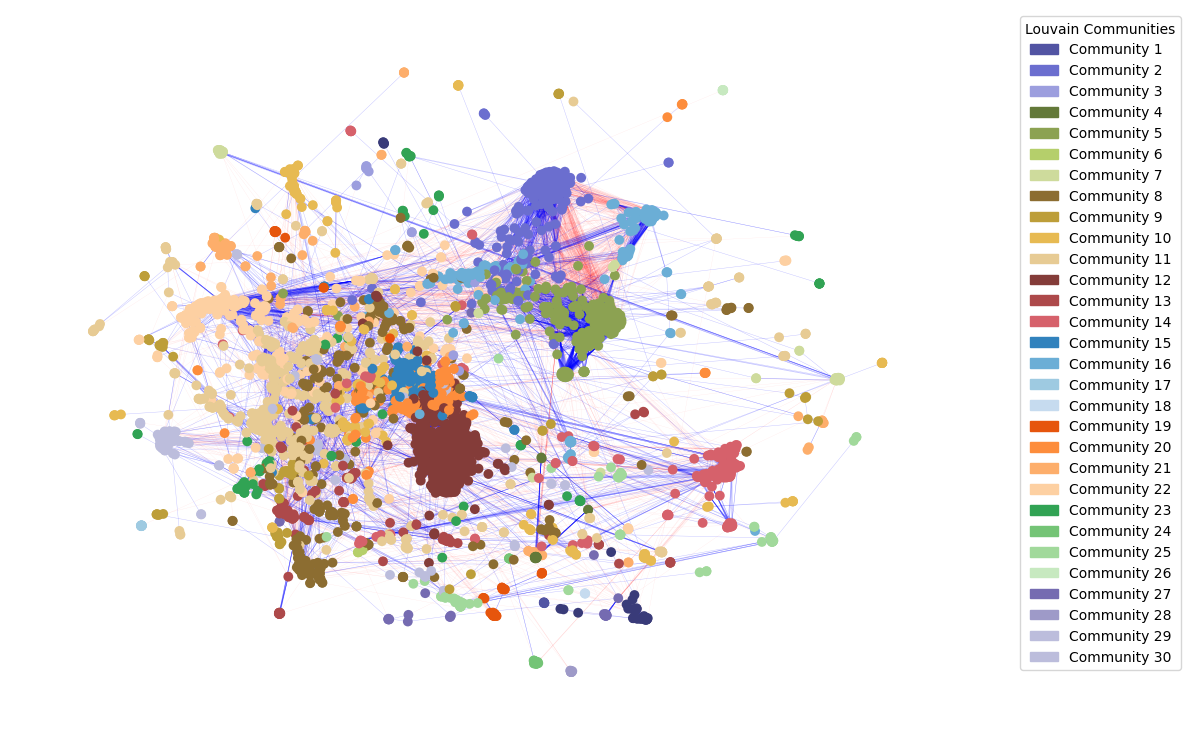

In [34]:
assert pos is not None, "Position dictionary 'pos' is not defined. It should have been created/loaded in earlier in the code."

node_comm = nx.get_node_attributes(H, "louvain_community")
edges_intra = [(u, v) for u, v in H.edges() if node_comm.get(u) == node_comm.get(v)]
edges_inter = [(u, v) for u, v in H.edges() if node_comm.get(u) != node_comm.get(v)]

cmap = plt.cm.get_cmap('tab20', len(louvain_communities))

cmap_b = plt.get_cmap('tab20b', 20)
cmap_c = plt.get_cmap('tab20c', 20)
combined_colors = np.vstack((cmap_b(np.arange(15)), cmap_c(np.arange(15))))
custom_cmap_30 = ListedColormap(combined_colors, name='custom_30_communities')

node_colors = [node_comm.get(n, -1) for n in H.nodes()]

fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx_edges(H, pos, edgelist=edges_inter, width=0.2, alpha=0.1, edge_color="red", ax=ax)
nx.draw_networkx_edges(H, pos, edgelist=edges_intra, width=0.3, alpha=0.25, edge_color="blue", ax=ax)
nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=50, cmap=custom_cmap_30, linewidths=0, ax=ax)

handles = []
for cid in range(len(louvain_communities)):
    color = custom_cmap_30(cid+1)
    patch = mpatches.Patch(color=color, label=f"Community {cid+1}")
    handles.append(patch)

ax.legend(handles=handles, title="Louvain Communities",
          loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10)

ax.set_axis_off()
plt.tight_layout()
plt.show()

### Creating communities based on category

In [35]:
# List of categories excluding 'top' and 'other'
categories = []
for node, data in H.nodes(data=True):
    dc = data['category']
    for c in dc:
        if c not in categories:
            categories.append(c)

categories.remove('top')
categories.remove('other')

In [36]:
# Category-based communities
# Using first category if not 'top' or 'other'. Otherwise try the second category if there is one. Else just categorize it as 'other'
category_comm = {'other': set()}
for node, data in H.nodes(data=True):
    dc = data['category']
    c = dc[0]
    if c in categories:
        if c not in category_comm:
            category_comm[c] = {node}
        else:
            category_comm[c].add(node)
    elif len(dc)>1:
        c2 = dc[1]
        if c2 in categories:
            if c2 not in category_comm:
                category_comm[c2] = {node}
            else:
                category_comm[c2].add(node)
        else:
            category_comm['other'].add(node)
    else:
        category_comm['other'].add(node)

In [38]:
# Stats on category-based communities:
category_commmunities = list(category_comm.values())
print("-"*50)

print(f"Number of category communities:", len(category_commmunities))
length_comm = [(cat, len(nodes)) for cat,nodes in category_comm.items()]
sizes = [s for i,s in sorted(length_comm, key = lambda x: x[1])]
print(f"The smallest community has {min(sizes)} nodes, the biggest community has {max(sizes)} nodes")
print()

# Modularity
modularity = nx.community.modularity(H, category_commmunities)
print(f"The modularity of the communities is: {modularity}")
print()

# Coverage and Performance
coverage, _ = nx.community.partition_quality(H, category_commmunities)
print(f"The coverage of the communities is: {coverage}")
print()

# Map node to community
node2comm = {}
for cat, nodes in category_comm.items():
    for n in nodes:
        node2comm[n] = cat

# Prepare per-community accumulators
comm_Ein = defaultdict(float)   # sum of (weighted) intra-community edges counted once
comm_edge_incident_to_outside = defaultdict(int)  # count of edges that touch community and other community
node_k = {}   # total (weighted) degree/strength per node
node_k_in = defaultdict(float)
node_k_by_comm = defaultdict(lambda: defaultdict(float))  # node -> comm -> k contribution

# Precompute degrees (strengths if weight)
for n in H.nodes():
    node_k[n] = H.degree(n)

# Iterate edges once to accumulate intra/inter counts
inter_edges_total = 0
for (u, v) in H.edges():
    w = 1.0 #edge weight
    cu = node2comm.get(u, None)
    cv = node2comm.get(v, None)
    if cu is None or cv is None:
        # ignore nodes not assigned to any community (or treat them as unique communities)
        continue
    if cu == cv:
        # intra-community: count once towards E_in of that community
        comm_Ein[cu] += 1
        # node-level internal contributions
        node_k_in[u] += 1
        node_k_in[v] += 1
        node_k_by_comm[u][cu] += 1
        node_k_by_comm[v][cv] += 1
    else:
        # inter-community edge
        inter_edges_total += 1  # count edges (unweighted count). If you want weighted inter-edge sum, use w.
        comm_edge_incident_to_outside[cu] += 1
        comm_edge_incident_to_outside[cv] += 1
        # nodes get external contributions
        node_k_by_comm[u][cv] += 1
        node_k_by_comm[v][cu] += 1
        node_k_in[u] += 0  # nothing added to internal
        node_k_in[v] += 0

# finalize community stats
comm_stats = {}
for cat, nodes  in category_comm.items():
    n = len(nodes)
    E_in = comm_Ein.get(cat, 0.0)
    density = 0.0
    if n >= 2:
        density = (2.0 * E_in) / (n * (n - 1))
    inter_edges = comm_edge_incident_to_outside.get(cat, 0)
    comm_stats[cat] = {
        'nodes': nodes,
        'N': n,
        'E_in': E_in,
        'density': density,
        'inter_edges': inter_edges
    }

# assemble node stats
node_stats = {}
for n in H.nodes():
    cat = node2comm.get(n, None)
    k = float(node_k.get(n, 0.0))
    k_in = float(node_k_in.get(n, 0.0))
    k_out = max(0.0, k - k_in)

    node_stats[n] = {
        'community': cat,
        'k': k,
        'k_in': k_in,
        'k_out': k_out
    }

# Density - how cohesive a community is
for cat, _ in comm_stats.items():
    print(f"The number of nodes of community {cat} is : {comm_stats[cat]['N']}")
    print(f"The density of community {cat} is: {round(comm_stats[cat]['density'],3)}")

print()

print("-"*50)

--------------------------------------------------
Number of category communities: 16
The smallest community has 11 nodes, the biggest community has 1279 nodes

The modularity of the communities is: 0.4141544281582987

The coverage of the communities is: 0.6384212433696834

The number of nodes of community other is : 50
The density of community other is: 0.003
The number of nodes of community entertainment is : 350
The density of community entertainment is: 0.014
The number of nodes of community politics is : 523
The density of community politics is: 0.01
The number of nodes of community sports is : 1279
The density of community sports is: 0.01
The number of nodes of community world is : 81
The density of community world is: 0.008
The number of nodes of community business is : 878
The density of community business is: 0.018
The number of nodes of community health is : 109
The density of community health is: 0.018
The number of nodes of community environment is : 142
The density of comm

In [39]:
# Potentially add as attribute
for cat, nodes in category_comm.items():
    for node in nodes:
        H.nodes[node]["category_community"] = cat
        nwdf.loc[nwdf['article id'] == node, "category_community"] = cat

### Creating communities based on countries

In [40]:
countries = []
for node, data in H.nodes(data=True):
    dc = data['country']
    if c not in countries:
        countries.append(dc)

In [41]:
country_comm = {}
for node, data in H.nodes(data=True):
    dc = data['country']
    if dc in countries:
        if dc not in country_comm:
            country_comm[dc] = {node}
        else:
            country_comm[dc].add(node)

In [42]:
country_commmunities = list(country_comm.values())
print("-"*50)

print(f"Number of category communities:", len(country_commmunities))
length_comm = [(cat, len(nodes)) for cat,nodes in country_comm.items()]
sizes = [s for i,s in sorted(length_comm, key = lambda x: x[1])]
print(f"The smallest community has {min(sizes)} nodes, the biggest community has {max(sizes)} nodes")
print()

# Modularity
modularity = nx.community.modularity(H, country_commmunities)
print(f"The modularity of the communities is: {modularity}")
print()

# Coverage and Performance
coverage, _ = nx.community.partition_quality(H, country_commmunities)
print()

# Map node to community
node2comm = {}
for cat, nodes in country_comm.items():
    for n in nodes:
        node2comm[n] = cat

# Prepare per-community accumulators
comm_Ein = defaultdict(float)   # sum of (weighted) intra-community edges counted once
comm_edge_incident_to_outside = defaultdict(int)  # count of edges that touch community and other community
node_k = {}   # total (weighted) degree/strength per node
node_k_in = defaultdict(float)
node_k_by_comm = defaultdict(lambda: defaultdict(float))  # node -> comm -> k contribution

# Precompute degrees (strengths if weight)
for n in H.nodes():
    node_k[n] = H.degree(n)

# Iterate edges once to accumulate intra/inter counts
inter_edges_total = 0
for (u, v) in H.edges():
    w = 1.0 #edge weight
    cu = node2comm.get(u, None)
    cv = node2comm.get(v, None)
    if cu is None or cv is None:
        # ignore nodes not assigned to any community (or treat them as unique communities)
        continue
    if cu == cv:
        # intra-community: count once towards E_in of that community
        comm_Ein[cu] += 1
        # node-level internal contributions
        node_k_in[u] += 1
        node_k_in[v] += 1
        node_k_by_comm[u][cu] += 1
        node_k_by_comm[v][cv] += 1
    else:
        # inter-community edge
        inter_edges_total += 1  # count edges (unweighted count). If you want weighted inter-edge sum, use w.
        comm_edge_incident_to_outside[cu] += 1
        comm_edge_incident_to_outside[cv] += 1
        # nodes get external contributions
        node_k_by_comm[u][cv] += 1
        node_k_by_comm[v][cu] += 1
        node_k_in[u] += 0  # nothing added to internal
        node_k_in[v] += 0

# finalize community stats
comm_stats = {}
for cat, nodes  in country_comm.items():
    n = len(nodes)
    E_in = comm_Ein.get(cat, 0.0)
    density = 0.0
    if n >= 2:
        density = (2.0 * E_in) / (n * (n - 1))
    inter_edges = comm_edge_incident_to_outside.get(cat, 0)
    comm_stats[cat] = {
        'nodes': nodes,
        'N': n,
        'E_in': E_in,
        'density': density,
        'inter_edges': inter_edges
    }

# assemble node stats
node_stats = {}
for n in H.nodes():
    cat = node2comm.get(n, None)
    k = float(node_k.get(n, 0.0))
    k_in = float(node_k_in.get(n, 0.0))
    k_out = max(0.0, k - k_in)

    node_stats[n] = {
        'community': cat,
        'k': k,
        'k_in': k_in,
        'k_out': k_out
    }

# Density - how cohesive a community is
for cat, _ in comm_stats.items():
    print(f"The number of nodes of community {cat} is : {comm_stats[cat]['N']}")
    print(f"The density of community {cat} is: {round(comm_stats[cat]['density'],3)}")

print()

print("-"*50)

--------------------------------------------------
Number of category communities: 67
The smallest community has 1 nodes, the biggest community has 2197 nodes

The modularity of the communities is: 0.20375759186069586


The number of nodes of community united kingdom is : 285
The density of community united kingdom is: 0.006
The number of nodes of community united states of america is : 2197
The density of community united states of america is: 0.007
The number of nodes of community canada is : 337
The density of community canada is: 0.009
The number of nodes of community south korea is : 19
The density of community south korea is: 0.035
The number of nodes of community namibia is : 10
The density of community namibia is: 0.022
The number of nodes of community singapore is : 51
The density of community singapore is: 0.023
The number of nodes of community australia is : 264
The density of community australia is: 0.006
The number of nodes of community france is : 17
The density of commun

### Creating dataframe for singular communities

In [44]:
comm_index = 16
assert comm_index < len(louvain_communities), "comm_index is out of range."
community_nodes = louvain_communities[comm_index]
community_subgraph = H.subgraph(community_nodes)
print("Number of nodes in selected community subgraph:", community_subgraph.number_of_nodes())
print("Percentage of total nodes in community subgraph:", round((community_subgraph.number_of_nodes() / H.number_of_nodes()) * 100, 2), "%")

assert combined_data_df is not None, "combined_data_df is not defined."

country_counts_lc = Counter([community_subgraph.nodes[article_id]["country"] for article_id in community_subgraph.nodes()])
country_counts_pd_lc = pd.DataFrame(list(country_counts_lc.items()), columns=["country", "count"])
df_lc = pd.merge(country_counts_pd_lc, combined_data_df[["country", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country", how="left")
df_lc.head()

Number of nodes in selected community subgraph: 198
Percentage of total nodes in community subgraph: 4.45 %


country  count  press freedom current rank  \
0  united states of america    109                        57.0   
1                     italy     42                        49.0   
2                    canada     23                        21.0   
3                 sri lanka      3                       139.0   
4                 singapore      1                       123.0   

   press freedom slope of ranks  corruption latest score  \
0                          1.41                     65.0   
1                          0.27                     54.0   
2                          0.14                     75.0   
3                          1.28                     32.0   
4                         -0.17                     84.0   

   corruption score slope  
0                   -0.74  
1                    1.32  
2                   -0.82  
3                   -0.37  
4                   -0.19

In [45]:
assert world is not None, "world GeoDataFrame is not defined."

df_fixed_lc = df_lc.copy()
df_fixed_lc["country"] = df_fixed_lc["country"].str.strip().str.lower()

name_fix = {
    "netherland": "netherlands",
}
df_fixed_lc["country"] = df_fixed_lc["country"].replace(name_fix)
df_fixed_lc["country_norm"] = df_fixed_lc["country"]

gdf_lc = world.merge(df_fixed_lc[["country_norm", "count", "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']], on="country_norm", how="inner")
gdf_lc["articles_per_million"] = round((gdf_lc["count"] / gdf_lc["POP_EST"]) * 10e6 , 2)
keep = ['country_norm', 'POP_EST', 'GDP_MD', 'INCOME_GRP', 'count', 'articles_per_million', 'geometry', "press freedom current rank", 'press freedom slope of ranks', 'corruption latest score', 'corruption score slope']
gdf_lc = gdf_lc[keep]
gdf_lc.rename(columns={"country_norm": "country", "POP_EST": "population", 'GDP_MD': "gross domestic product (millions usd)", "INCOME_GRP": "income group", "count": "number of articles", "articles_per_million": "articles per million capita"}, inplace=True)

### Plotting interactive cloropeth map for singular louvain community

In [106]:
gdf_lc.explore(column="articles per million capita", legend=True)

### **Insights for subset of communities**

In [47]:
def shannon_entropy(probs):
    probs = np.asarray(probs, dtype=float)
    probs = probs[probs > 0]
    if len(probs) == 0:
        return 0.0
    return -np.sum(probs * np.log2(probs))

def category_to_main(cat_value):
    if isinstance(cat_value, list):
        return cat_value[0] if len(cat_value) > 0 else np.nan
    if pd.isna(cat_value):
        return np.nan
    return cat_value  

def compute_community_profiles_with_entropy(df):
    df = df.copy()
    if 'category' in df.columns:
        df['category_main'] = df['category'].apply(category_to_main)
    else:
        df['category_main'] = np.nan

    group_cols = ['category_main', 'country', 'continent', 'income_group']
    group_cols = [c for c in group_cols if c in df.columns]

    records = []

    for comm, sub in df.groupby('louvain_community'):
        rec = {'louvain_community': comm, 'n_nodes': len(sub)}
        for col in group_cols:
            vc = sub[col].value_counts(normalize=True, dropna=True)
            ent = shannon_entropy(vc.values)
            rec[f'{col}_entropy'] = ent
            if len(vc) > 0:
                top_label = vc.index[0]
                top_prop = vc.iloc[0]
            else:
                top_label = np.nan
                top_prop = np.nan
            rec[f'{col}_top_label'] = top_label
            rec[f'{col}_top_prop'] = top_prop
        records.append(rec)

    profiles = pd.DataFrame(records).sort_values('n_nodes', ascending=False)
    return profiles

# Heterogenitet inde i communities

def compute_within_community_variance(df):
    df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)
    candidate_features = [
        'description_sentiment_score',
        'title_sentiment_score',
        'press_freedom_index_score',
        'press_freedom_current_rank',
        'corruption_latest_score',
        'corruption_score_slope',
        'median_age_2024',
        'gdp_per_capita_2024_international_dollars',
        'average_years_of_schooling_2023',
        'population', 'income_rank'
    ]
    features = [c for c in candidate_features if c in df.columns]

    grouped = (
        df.groupby('louvain_community')[features]
          .agg(['mean', 'std', 'var', 'count'])
    )
    return grouped

#  Emotionelle profiler pr. community

def compute_emotion_profiles_and_pca(df):
    emotion_candidates = [
        'anticipation_d','trust_d','joy_d','positive_d','surprise_d',
        'anger_d','disgust_d','negative_d','fear_d','sadness',
        'joy','positive','surprise','trust','anger','anticipation',
        'disgust','negative','fear','sadness'
    ]
    emotions = [c for c in emotion_candidates if c in df.columns]
    if not emotions:
        raise ValueError()

    community_emotions = df.groupby('louvain_community')[emotions].mean()

    return community_emotions

profiles = compute_community_profiles_with_entropy(nwdf)

within_var = compute_within_community_variance(nwdf)

community_emotions = compute_emotion_profiles_and_pca(nwdf)

within_var_reset = within_var.reset_index()
within_var_reset.columns = ['_'.join(col).strip() if col[1] else col[0] for col in within_var_reset.columns.values]
within_var_reset.rename(columns={'louvain_community_': 'louvain_community'}, inplace=True)
community_emotions_reset = community_emotions.reset_index()
community_emotions_reset.rename(columns={'louvain_community': 'louvain_community'}, inplace=True)
comm = pd.merge(profiles, within_var_reset, on='louvain_community')
comm = pd.merge(comm, community_emotions_reset, on='louvain_community')

communities_chosen = [3,6,9,12,13,16,17,21,23]
communities_chosen = [c - 1 for c in communities_chosen]
cols = [
    'louvain_community', 
    'n_nodes',
    'category_main_top_label', 'category_main_top_prop',
    'income_group_top_label', 'income_group_top_prop',
    'median_age_2024_mean',
    'average_years_of_schooling_2023_mean',
    'corruption_score_slope_mean', 'description_sentiment_score_mean',
    'country_top_label', 'country_top_prop',
]

nice = comm[cols].copy()

for c in ['category_main_top_prop', 'income_group_top_prop']:
    nice[c] = (nice[c] * 100).round(1)

nice = nice.rename(columns={
    'louvain_community': 'community',
    'n_nodes': 'N',
    'category_main_top_label': 'main_topic',
    'category_main_top_prop': 'main_topic_%',
    'continent_top_label': 'main_continent',
    'continent_top_prop': 'main_continent_%',
    'income_group_top_label': 'main_income_group', 
    'income_group_top_prop': 'main_income_group_%',
    'median_age_2024_mean': 'median_age_mean',
    'average_years_of_schooling_2023_mean': 'avg_school_years_mean',
    'gdp_pc_2024_kUSD': 'gdp_pc_2024_INTD'
})

nice = nice.sort_values('community', ascending=True)

display(nice[nice['community'].isin(communities_chosen)].reset_index(drop=True))

<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\1436228896.py:49: SyntaxWarning: invalid escape sequence '\d'
  df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)


community    N  main_topic  main_topic_%       main_income_group  \
0        2.0  184    business          73.4    1. High income: OECD   
1        5.0  231    business          77.1    1. High income: OECD   
2        8.0  391    politics          40.7  4. Lower middle income   
3       11.0  681         top          46.4    1. High income: OECD   
4       12.0  427      sports          79.9    1. High income: OECD   
5       15.0  262      sports          92.4    1. High income: OECD   
6       16.0  198    business          69.7    1. High income: OECD   
7       20.0  322      sports          90.1    1. High income: OECD   
8       22.0  316  technology          44.9    1. High income: OECD   

   main_income_group_%  median_age_mean  avg_school_years_mean  \
0                 89.6        37.894742              11.349478   
1                 85.6        34.818043              10.335599   
2                 58.2        28.045063               8.673601   
3                 65.7        33.245518              10.076968   
4                 98.4        38.388745              12.865508   
5                 95.8        38.931271              11.538615   
6                 95.9        43.149281              11.742944   
7                 88.3        37.377795              12.140580   
8                 60.9        34.772536              10.225880   

   corruption_score_slope_mean  description_sentiment_score_mean  \
0                    -0.570294                          5.518538   
1                    -0.570263                          5.518062   
2                    -0.154945                          5.403423   
3                    -0.390061                          5.241719   
4                    -0.728330                          5.485928   
5                    -0.676432                          5.356881   
6                    -0.248279                          5.520597   
7                    -0.579722                          5.425970   
8                    -0.261216                          5.500385   

          country_top_label  country_top_prop  
0  united states of america          0.663043  
1  united states of america          0.701299  
2                     india          0.304348  
3  united states of america          0.371512  
4  united states of america          0.889930  
5  united states of america          0.816794  
6  united states of america          0.550505  
7  united states of america          0.468944  
8  united states of america          0.291139

### **Differences in some attributes for communities**

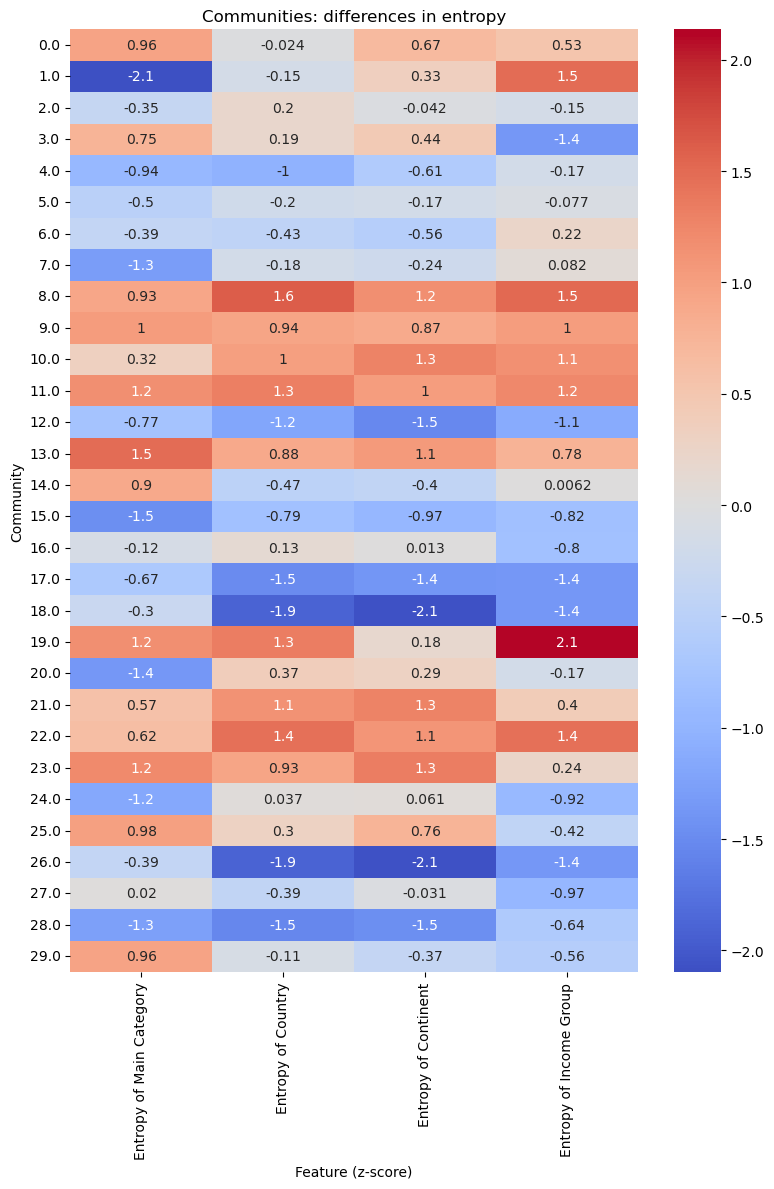

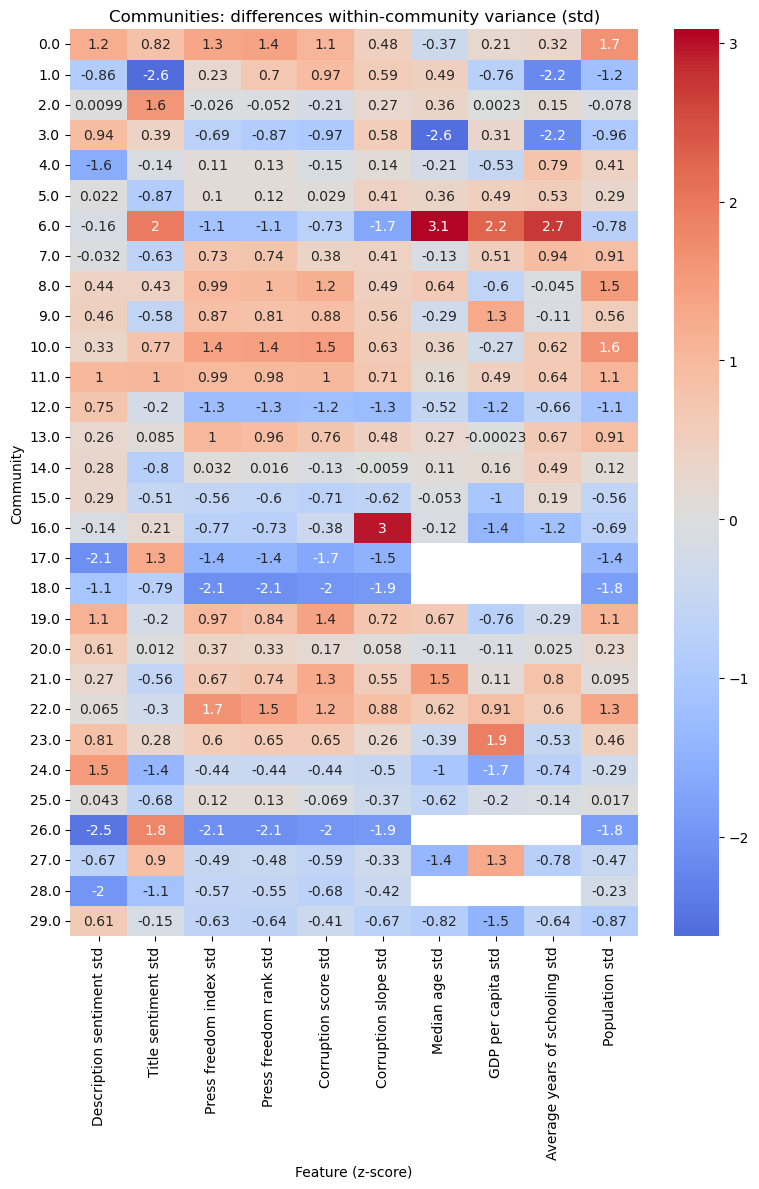

In [48]:
features_entropy = ['category_main_entropy', 'country_entropy', 'continent_entropy', 'income_group_entropy']
features_std = ['description_sentiment_score_std', 'title_sentiment_score_std', 
            'press_freedom_index_score_std', 'press_freedom_current_rank_std', 
            'corruption_latest_score_std', 'corruption_score_slope_std', 'median_age_2024_std', 
            'gdp_per_capita_2024_international_dollars_std', 'average_years_of_schooling_2023_std', 
            'population_std']
heat = comm[['louvain_community'] + features_entropy].set_index('louvain_community')

heat_z = (heat - heat.mean()) / heat.std()


plt.figure(figsize=(8, 12))
sns.heatmap(
    heat_z.sort_index(),
    cmap='coolwarm',
    center=0,
    annot=True
)
plt.title('Communities: differences in entropy')
plt.ylabel('Community')
plt.xlabel('Feature (z-score)')
plt.xticks(ticks=np.arange(len(features_entropy))+0.5, labels=['Entropy of Main Category', 'Entropy of Country', 'Entropy of Continent', 'Entropy of Income Group'])
plt.tight_layout()
plt.show()

features_std = ['description_sentiment_score_std', 'title_sentiment_score_std', 
            'press_freedom_index_score_std', 'press_freedom_current_rank_std', 
            'corruption_latest_score_std', 'corruption_score_slope_std', 'median_age_2024_std', 
            'gdp_per_capita_2024_international_dollars_std', 'average_years_of_schooling_2023_std', 
            'population_std']
heat = comm[['louvain_community'] + features_std].set_index('louvain_community')

heat_z = (heat - heat.mean()) / heat.std()

plt.figure(figsize=(8, 12))
sns.heatmap(
    heat_z.sort_index(),
    cmap='coolwarm',
    center=0,
    annot=True
)
plt.title('Communities: differences within-community variance (std)')
plt.ylabel('Community')
plt.xlabel('Feature (z-score)')
plt.xticks(ticks=np.arange(len(features_std))+0.5, labels=['Description sentiment std', 'Title sentiment std', 'Press freedom index std', 'Press freedom rank std', 'Corruption score std', 'Corruption slope std', 'Median age std', 'GDP per capita std', 'Average years of schooling std', 'Population std'])

plt.tight_layout()
plt.show()


### **Centralities and their correlations**

Calculating best minimal value for power law fit
c:\Users\bella\miniconda3\envs\02805SGI\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


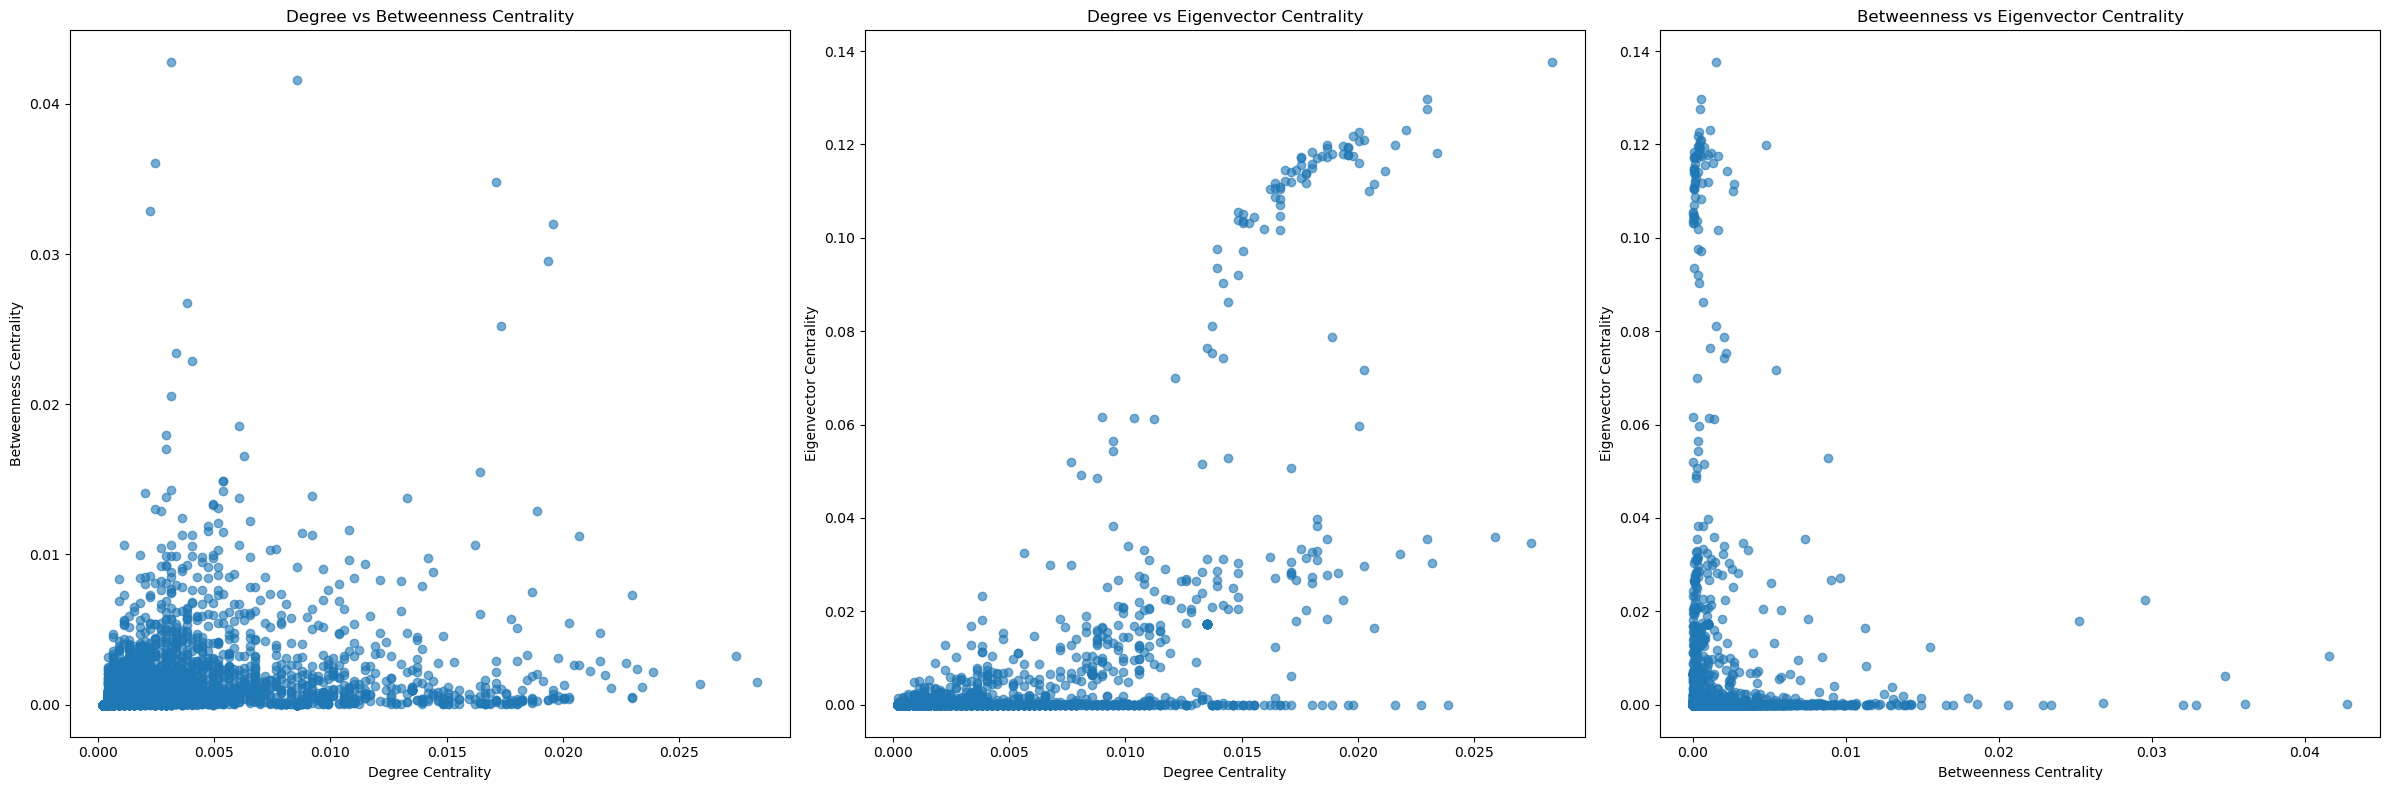

Power-law exponent (alpha): 9.192472307941019
Degree assortativity coefficient: 0.638900362715566
Correlation between degree and betweenness centrality: 0.5609053843400901 with p-value: 0.0
Correlation between degree and eigenvector centrality: 0.6454338189536014 with p-value: 0.0
Correlation between betweenness and eigenvector centrality: 0.29639815105679496 with p-value: 7.420070014844857e-91


In [49]:
deg_path = 'degree_centrality.pkl'
bet_path = 'betweenness_centrality.pkl'
eigen_path = 'eigenvector_centrality.pkl'

fit = powerlaw.Fit([H.degree(n) for n in H.nodes()]).alpha
assortativity = nx.degree_assortativity_coefficient(H)

if os.path.exists(deg_path):
    with open(deg_path, 'rb') as f:
        deg_centrality = pickle.load(f)
else:
    deg_centrality = list(nx.degree_centrality(H).items())
    with open(deg_path, 'wb') as f:
        pickle.dump(deg_centrality, f)

if os.path.exists(bet_path):
    with open(bet_path, 'rb') as f:
        bet_centrality = pickle.load(f)
else:
    bet_centrality = list(nx.betweenness_centrality(H).items())
    with open(bet_path, 'wb') as f:
        pickle.dump(bet_centrality, f)

if os.path.exists(eigen_path):
    with open(eigen_path, 'rb') as f:
        eigen_centrality = pickle.load(f)
else:
    eigen_centrality = list(nx.eigenvector_centrality(H).items())
    with open(eigen_path, 'wb') as f:
        pickle.dump(eigen_centrality, f)

deg_bet = stats.spearmanr([v for k,v in deg_centrality], [v for k,v in bet_centrality])
deg_eigen = stats.spearmanr([v for k,v in deg_centrality], [v for k,v in eigen_centrality])
bet_eigen = stats.spearmanr([v for k,v in bet_centrality], [v for k,v in eigen_centrality])

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax = ax.flatten()

ax[0].scatter(
    [dc[1] for dc in deg_centrality],
    [bc[1] for bc in bet_centrality],
    alpha=0.6
)
ax[0].set_xlabel("Degree Centrality")
ax[0].set_ylabel("Betweenness Centrality")
ax[0].set_title("Degree vs Betweenness Centrality")

ax[1].scatter(
    [dc[1] for dc in deg_centrality],
    [bc[1] for bc in eigen_centrality],
    alpha=0.6
)
ax[1].set_xlabel("Degree Centrality")
ax[1].set_ylabel("Eigenvector Centrality")
ax[1].set_title("Degree vs Eigenvector Centrality")

ax[2].scatter(
    [bc[1] for bc in bet_centrality],
    [ec[1] for ec in eigen_centrality],
    alpha=0.6
)
ax[2].set_xlabel("Betweenness Centrality")
ax[2].set_ylabel("Eigenvector Centrality")
ax[2].set_title("Betweenness vs Eigenvector Centrality")
plt.tight_layout()
plt.show()

print("Power-law exponent (alpha):", fit)
print("Degree assortativity coefficient:", assortativity)
print("Correlation between degree and betweenness centrality:", deg_bet[0], "with p-value:", deg_bet[1])
print("Correlation between degree and eigenvector centrality:", deg_eigen[0], "with p-value:", deg_eigen[1])
print("Correlation between betweenness and eigenvector centrality:", bet_eigen[0], "with p-value:", bet_eigen[1])

### **Centralities across categories and communities**

In [50]:
from scipy.stats import kruskal
import statistics

unique_data = [list(x) for x in set(tuple(x) for x in list(nwdf['category']))]
categories = []
for c in unique_data:
    for category in c:
        categories.append(category)
categories = list(set(categories))
category_deg = {category: [] for category in categories}
category_bet = {category: [] for category in categories}
category_eigen = {category: [] for category in categories}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_deg[category].append(centrality)
        else:
            category_deg[article_categories].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_bet[category].append(centrality)
        else:
            category_bet[article_categories].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_categories = nwdf[nwdf['article id'] == article]['category'].values[0]
        if isinstance(article_categories, list):
            for category in article_categories:
                category_eigen[category].append(centrality)
        else:
            category_eigen[article_categories].append(centrality)

category_stats = {}
for category in categories:
    deg_values = category_deg[category]
    bet_values = category_bet[category]
    eigen_values = category_eigen[category]
    if len(deg_values) > 0:
        category_stats[category] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }
deg_data = [category_deg[category] for category in categories if len(category_deg[category]) > 0]
bet_data = [category_bet[category] for category in categories if len(category_bet[category]) > 0]
eigen_data = [category_eigen[category] for category in categories if len(category_eigen[category]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across categories: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across categories: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across categories: stat =", eigen_stat, ", p-value =", eigen_p)

communities = set(nwdf['louvain_community'])
community_deg = {community: [] for community in communities}
community_bet = {community: [] for community in communities}
community_eigen = {community: [] for community in communities}

for article, centrality in deg_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_deg[community].append(centrality)
        else:
            community_deg[article_communities].append(centrality)

for article, centrality in bet_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_bet[community].append(centrality)
        else:
            community_bet[article_communities].append(centrality)

for article, centrality in eigen_centrality:
    if article in nwdf['article id'].values:
        article_communities = nwdf[nwdf['article id'] == article]['louvain_community'].values[0]
        if isinstance(article_communities, list):
            for community in article_communities:
                community_eigen[community].append(centrality)
        else:
            community_eigen[article_communities].append(centrality)

community_stats = {}
for community in communities:
    deg_values = community_deg[community]
    bet_values = community_bet[community]
    eigen_values = community_eigen[community]
    if len(deg_values) > 0:
        community_stats[community] = {
            'deg_mean': statistics.mean(deg_values),
            'deg_median': statistics.median(deg_values),
            'deg_std': statistics.stdev(deg_values) if len(deg_values) > 1 else 0,
            'bet_mean': statistics.mean(bet_values) if len(bet_values) > 0 else 0,
            'bet_median': statistics.median(bet_values) if len(bet_values) > 0 else 0,
            'bet_std': statistics.stdev(bet_values) if len(bet_values) > 1 else 0,
            'eigen_mean': statistics.mean(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_median': statistics.median(eigen_values) if len(eigen_values) > 0 else 0,
            'eigen_std': statistics.stdev(eigen_values) if len(eigen_values) > 1 else 0,
        }
deg_data = [community_deg[community] for community in communities if len(community_deg[community]) > 0]
bet_data = [community_bet[community] for community in communities if len(community_bet[community]) > 0]
eigen_data = [community_eigen[community] for community in communities if len(community_eigen[community]) > 0]
deg_stat, deg_p = kruskal(*deg_data)
bet_stat, bet_p = kruskal(*bet_data)
eigen_stat, eigen_p = kruskal(*eigen_data)
print("Kruskal-Wallis test for Degree Centrality across communities: stat =", deg_stat, ", p-value =", deg_p)
print("Kruskal-Wallis test for Betweenness Centrality across communities: stat =", bet_stat, ", p-value =", bet_p)
print("Kruskal-Wallis test for Eigenvector Centrality across communities: stat =", eigen_stat, ", p-value =", eigen_p)

Kruskal-Wallis test for Degree Centrality across categories: stat = 414.8225571819382 , p-value = 2.8356822460670926e-78
Kruskal-Wallis test for Betweenness Centrality across categories: stat = 28.39255164845209 , p-value = 0.028368953380734658
Kruskal-Wallis test for Eigenvector Centrality across categories: stat = 1474.086804645925 , p-value = 1.906676642154571e-304
Kruskal-Wallis test for Degree Centrality across communities: stat = 989.0096477272597 , p-value = 1.815993334363433e-189
Kruskal-Wallis test for Betweenness Centrality across communities: stat = 103.86625566935768 , p-value = 2.332367830869688e-10
Kruskal-Wallis test for Eigenvector Centrality across communities: stat = 2726.0341897579983 , p-value = 0.0


C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([category_deg[category] for category in categories if len(category_deg[category]) > 0], labels=[category for category in categories if len(category_deg[category]) > 0], vert=True)
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([category_bet[category] for category in categories if len(category_bet[category]) > 0], labels=[category for category in categories if len(category_bet[category]) > 0], vert=True)
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 

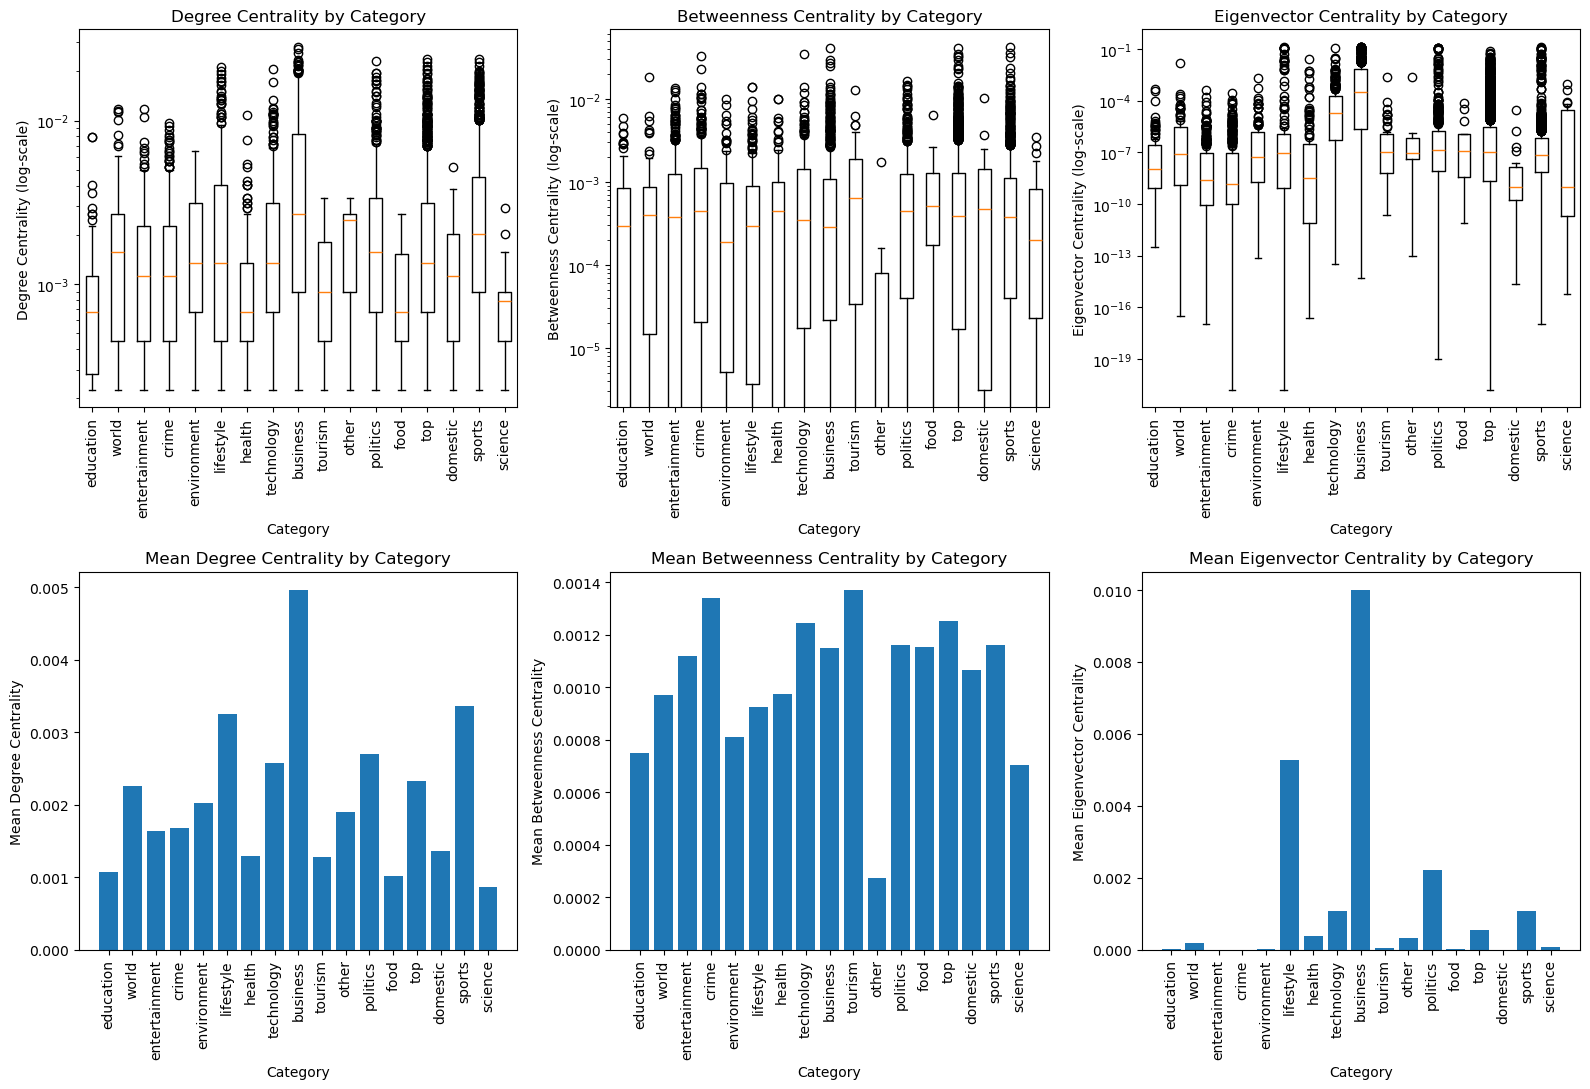

C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot([community_deg[category] for category in communities if len(community_deg[category]) > 0], labels=[category for category in communities if len(community_deg[category]) > 0], vert=True)
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot([community_bet[category] for category in communities if len(community_bet[category]) > 0], labels=[category for category in communities if len(community_bet[category]) > 0], vert=True)
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\569798736.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of box

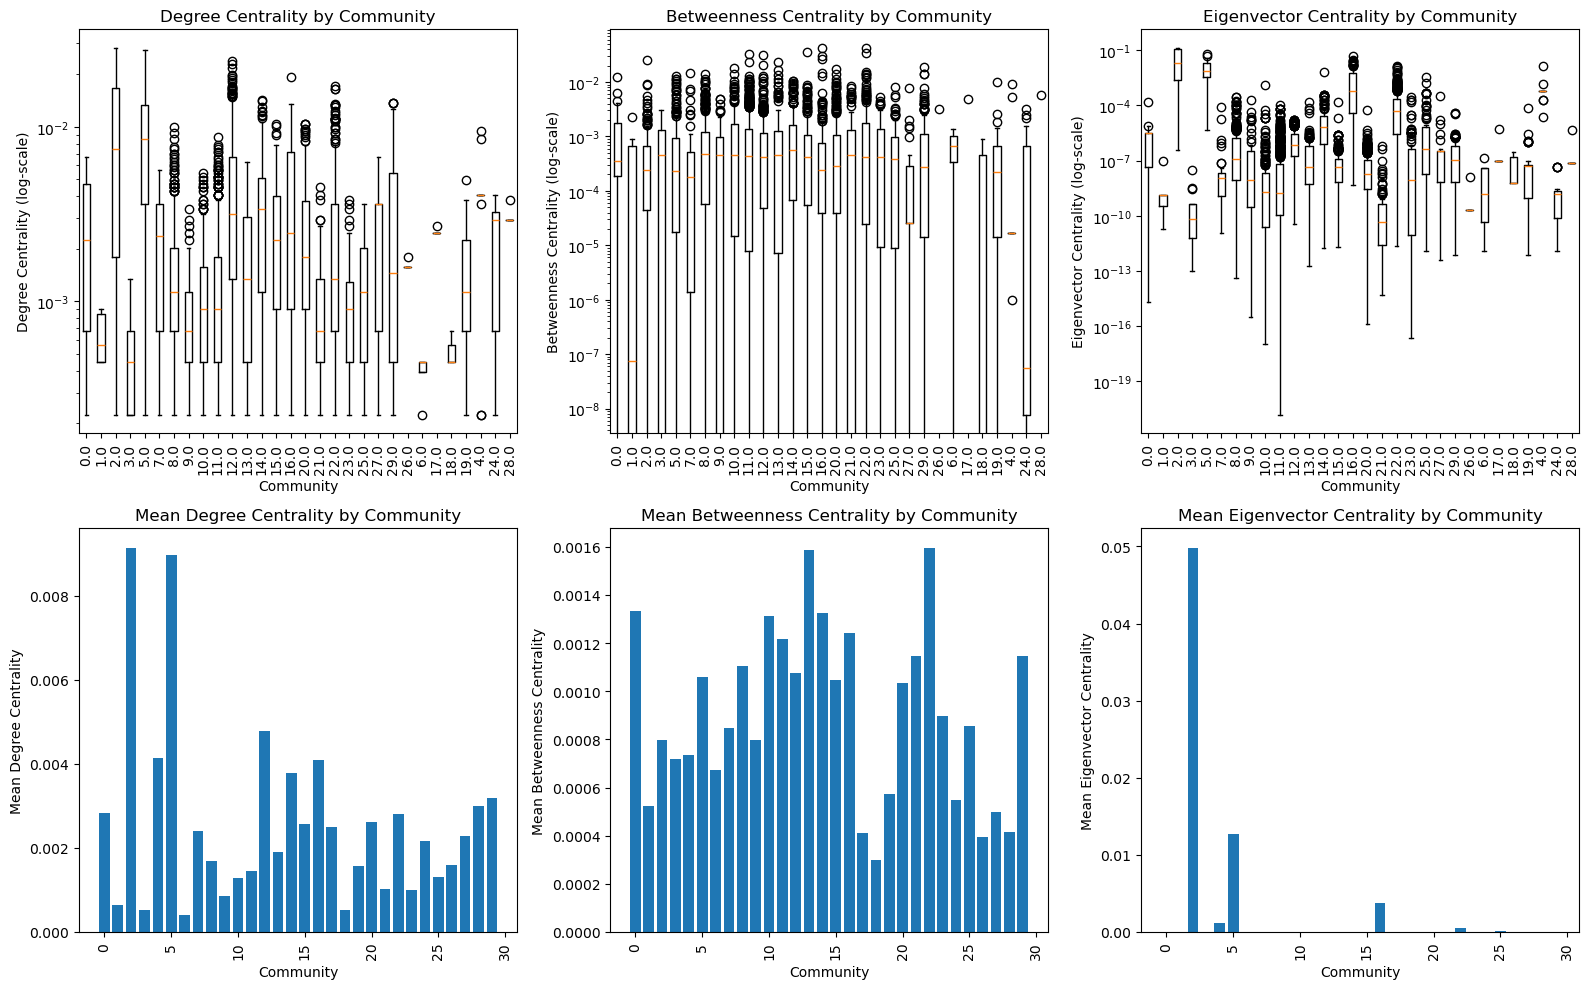

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(16, 11))
ax = ax.flatten()
ax[0].boxplot([category_deg[category] for category in categories if len(category_deg[category]) > 0], labels=[category for category in categories if len(category_deg[category]) > 0], vert=True)
ax[0].set_title("Degree Centrality by Category")
ax[0].set_ylabel("Degree Centrality (log-scale)")
ax[0].set_xlabel("Category")
ax[0].set_yscale('log')
ax[0].tick_params(axis='x', rotation=90)

ax[1].boxplot([category_bet[category] for category in categories if len(category_bet[category]) > 0], labels=[category for category in categories if len(category_bet[category]) > 0], vert=True)
ax[1].set_title("Betweenness Centrality by Category")
ax[1].set_ylabel("Betweenness Centrality (log-scale)")
ax[1].set_xlabel("Category")
ax[1].set_yscale('log')
ax[1].tick_params(axis='x', rotation=90)

ax[2].boxplot([category_eigen[category] for category in categories if len(category_eigen[category]) > 0], labels=[category for category in categories if len(category_eigen[category]) > 0], vert=True)
ax[2].set_title("Eigenvector Centrality by Category")
ax[2].set_ylabel("Eigenvector Centrality (log-scale)")
ax[2].set_xlabel("Category")
ax[2].set_yscale('log')
ax[2].tick_params(axis='x', rotation=90)

ax[3].bar([category for category in categories if category in category_stats], [category_stats[category]['deg_mean'] for category in categories if category in category_stats])
ax[3].set_title("Mean Degree Centrality by Category")
ax[3].set_ylabel("Mean Degree Centrality")
ax[3].set_xlabel("Category")
ax[3].tick_params(axis='x', rotation=90)

ax[4].bar([category for category in categories if category in category_stats], [category_stats[category]['bet_mean'] for category in categories if category in category_stats])
ax[4].set_title("Mean Betweenness Centrality by Category")
ax[4].set_ylabel("Mean Betweenness Centrality")
ax[4].set_xlabel("Category")
ax[4].tick_params(axis='x', rotation=90)

ax[5].bar([category for category in categories if category in category_stats], [category_stats[category]['eigen_mean'] for category in categories if category in category_stats])
ax[5].set_title("Mean Eigenvector Centrality by Category")
ax[5].set_ylabel("Mean Eigenvector Centrality")
ax[5].set_xlabel("Category")
ax[5].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 3, figsize=(16, 10))
ax = ax.flatten()
ax[0].boxplot([community_deg[category] for category in communities if len(community_deg[category]) > 0], labels=[category for category in communities if len(community_deg[category]) > 0], vert=True)
ax[0].set_title("Degree Centrality by Community")
ax[0].set_ylabel("Degree Centrality (log-scale)")
ax[0].set_xlabel("Community")
ax[0].set_yscale('log')
ax[0].tick_params(axis='x', rotation=90)

ax[1].boxplot([community_bet[category] for category in communities if len(community_bet[category]) > 0], labels=[category for category in communities if len(community_bet[category]) > 0], vert=True)
ax[1].set_title("Betweenness Centrality by Community")
ax[1].set_ylabel("Betweenness Centrality (log-scale)")
ax[1].set_xlabel("Community")
ax[1].set_yscale('log')
ax[1].tick_params(axis='x', rotation=90)

ax[2].boxplot([community_eigen[category] for category in communities if len(community_eigen[category]) > 0], labels=[category for category in communities if len(community_eigen[category]) > 0], vert=True)
ax[2].set_title("Eigenvector Centrality by Community")
ax[2].set_ylabel("Eigenvector Centrality (log-scale)")
ax[2].set_xlabel("Community")
ax[2].set_yscale('log')
ax[2].tick_params(axis='x', rotation=90)

ax[3].bar([category for category in communities if category in community_stats], [community_stats[category]['deg_mean'] for category in communities if category in community_stats])
ax[3].set_title("Mean Degree Centrality by Community")
ax[3].set_ylabel("Mean Degree Centrality")
ax[3].set_xlabel("Community")
ax[3].tick_params(axis='x', rotation=90)

ax[4].bar([category for category in communities if category in community_stats], [community_stats[category]['bet_mean'] for category in communities if category in community_stats])
ax[4].set_title("Mean Betweenness Centrality by Community")
ax[4].set_ylabel("Mean Betweenness Centrality")
ax[4].set_xlabel("Community")
ax[4].tick_params(axis='x', rotation=90)

ax[5].bar([category for category in communities if category in community_stats], [community_stats[category]['eigen_mean'] for category in communities if category in community_stats])
ax[5].set_title("Mean Eigenvector Centrality by Community")
ax[5].set_ylabel("Mean Eigenvector Centrality")
ax[5].set_xlabel("Community")
ax[5].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

## Creating Heatmaps for subset of communities

In [52]:
interest_lc_ids = [9, 23, 17, 12, 13, 3, 6, 21, 16]

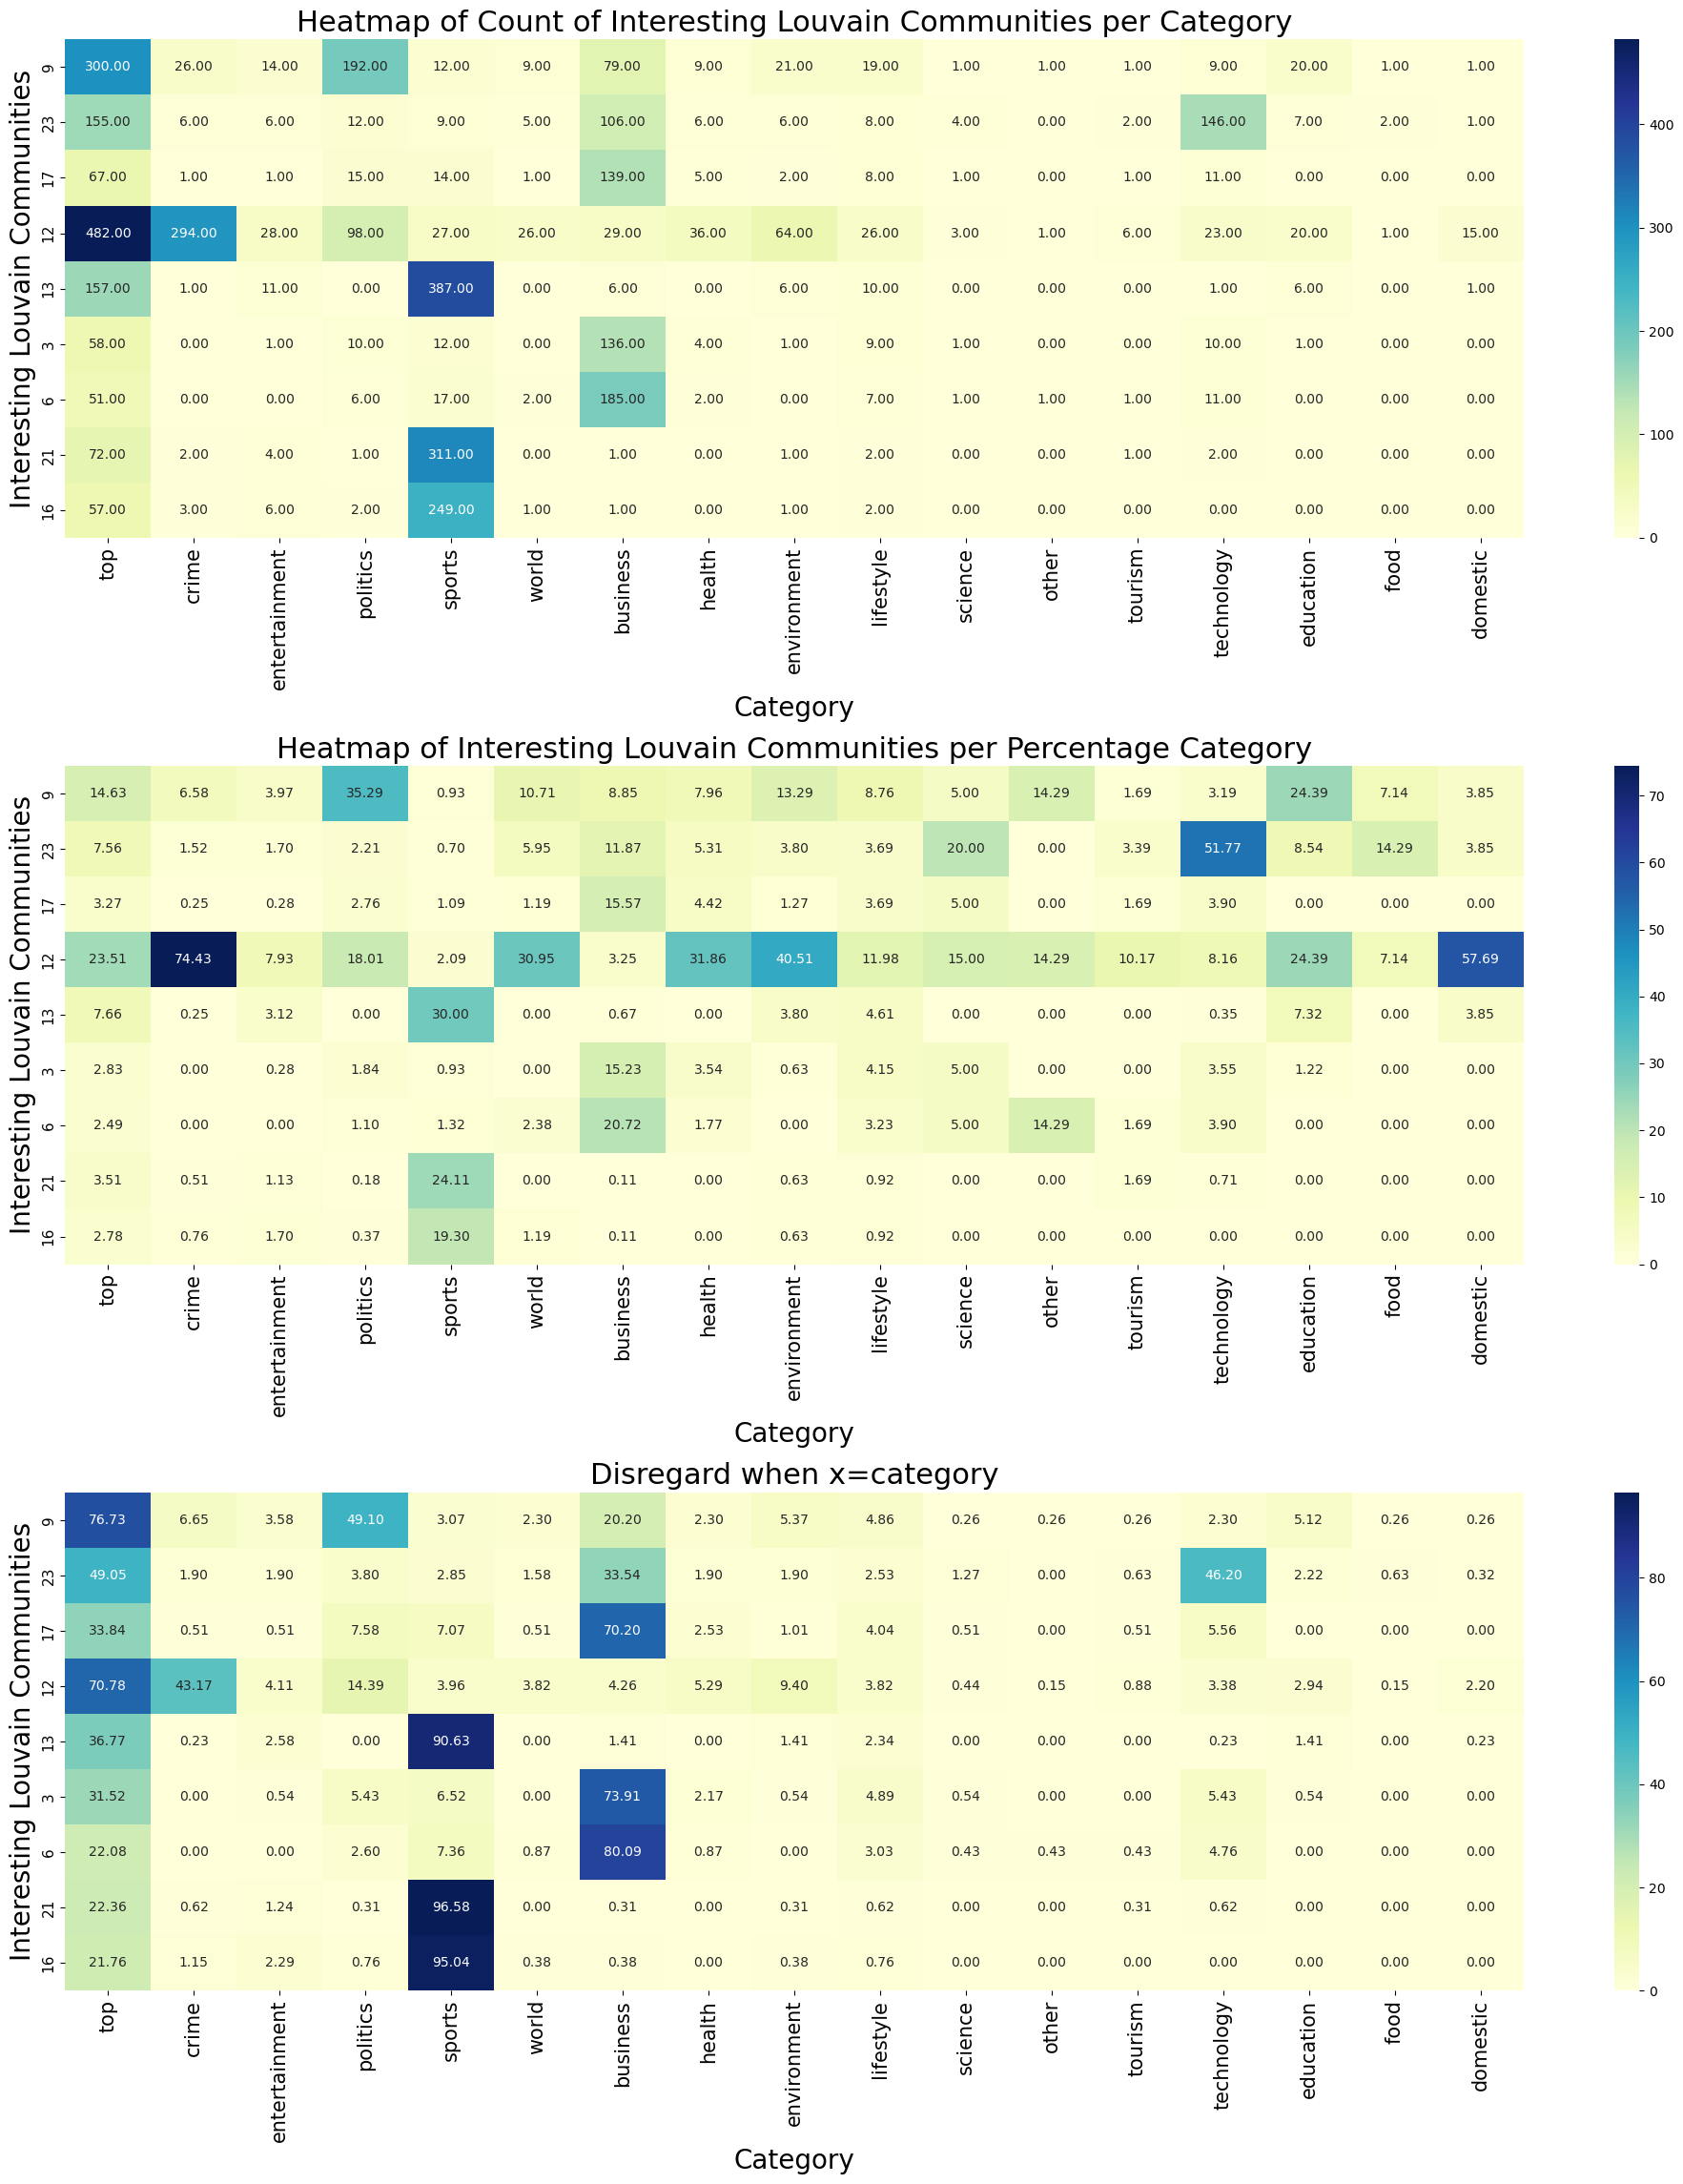

In [53]:
# Set params:
N_top_countries = 20 # Relevant for 'Top Countries' selection
n_communities = 19 # Relevant for 'Top Louvain Community' selection
n_top_categories = 5

category_counts_lcc = Counter([H.nodes[article_id]["category"][i] for article_id in H.nodes() for i in range(len(H.nodes[article_id]["category"]))])
country_counts_lcc = Counter([H.nodes[article_id]["country"] for article_id in H.nodes()])

# Relevant lists
def calc_louvain_communities():
    return [community_idx+1 for community_idx, _ in enumerate(louvain_communities)]
def calc_interesting_louvain_communities():
    return interest_lc_ids
def calc_top_louvain_communities():
    top_N_comms_id = []
    for i in range(n_communities):
        largest_comm_id = None
        for j, comm in enumerate(louvain_communities):
            if (not largest_comm_id or len(comm) > len(louvain_communities[largest_comm_id-1])) and j+1 not in top_N_comms_id:
                largest_comm_id = j+1
        top_N_comms_id.append(largest_comm_id)
    return sorted(top_N_comms_id)
def calc_countries():
    return nwdf['country'].explode().unique()
def calc_top_countries():
    return [country for country, _ in country_counts_lcc.most_common(N_top_countries)]
def calc_categories():
    return nwdf['category'].explode().unique()
def calc_top_categories():
    return [category for category, _ in category_counts_lcc.most_common(n_top_categories)]
def calc_continents():
    return nwdf['continent'].explode().unique()[pd.notna(nwdf['continent'].explode().unique())]   
    
param_selector_dict = {
    'Country': ['country', calc_countries],
    'Top Countries': ['country', calc_top_countries],
    'Category': ['category', calc_categories],
    'Top Categories': ['category', calc_top_categories],
    'Continent': ['continent', calc_continents],
    'Louvain Community': ['louvain_community', calc_louvain_communities],
    'Top Louvain Communities': ['louvain_community', calc_top_louvain_communities],
    'Interesting Louvain Communities': ['louvain_community', calc_interesting_louvain_communities]
}

def calc_heatmap(x_param, y_param, percentage=None):
    x = param_selector_dict[x_param][1]()
    y = param_selector_dict[y_param][1]()

    # Initializing empty heatmap dataframe
    heatmap_data = pd.DataFrame(0.0, index=y, columns=x)

    # Filling heatmap dataframe with counts
    for article in H.nodes(data=True):
        article_x_value = article[1][param_selector_dict[x_param][0]]
        if param_selector_dict[x_param][0] == 'louvain_community':
            article_x_value += 1
        article_y_value = article[1][param_selector_dict[y_param][0]]
        if param_selector_dict[y_param][0] == 'louvain_community':
            article_y_value += 1
        if param_selector_dict[x_param][0] == 'country' and isinstance(article_x_value, list):
            article_x_value = article_x_value[0]
        if param_selector_dict[y_param][0] == 'country' and isinstance(article_y_value, list):
            article_y_value = article_y_value[0]
        if param_selector_dict[x_param][0] == 'category' and isinstance(article_x_value, list):
            for a_x_v in article_x_value:
                if a_x_v in x and article_y_value in y:
                    heatmap_data.at[article_y_value, a_x_v] += 1
        elif param_selector_dict[y_param][0] == 'category' and isinstance(article_y_value, list):
            for a_y_v in article_y_value:
                if article_x_value in x and a_y_v in y:
                    heatmap_data.at[a_y_v, article_x_value] += 1
        elif article_x_value in x and article_y_value in y:
            heatmap_data.at[article_y_value, article_x_value] += 1
          

    # Converting counts to percentages if specified
    if percentage == 'percentage_of_x':
        for x_value in x:
            total_count = 0
            for node in H.nodes(data=True):
                article_x_value = node[1][param_selector_dict[x_param][0]]
                if param_selector_dict[x_param][0] == 'louvain_community':
                    article_x_value += 1
                if param_selector_dict[x_param][0] == 'country' and isinstance(article_x_value, list):
                    article_x_value = article_x_value[0]
                if param_selector_dict[x_param][0] == 'category' and isinstance(article_x_value, list):
                    for a_x_v in article_x_value:
                        if a_x_v == x_value:
                            total_count += 1
                elif article_x_value == x_value:
                    total_count += 1
            if total_count > 0:
                heatmap_data.loc[:, x_value] = (heatmap_data.loc[:, x_value] / total_count) * 100
    elif percentage == 'percentage_of_y':
        for y_value in y:
            total_count = 0
            for node in H.nodes(data=True):
                article_y_value = node[1][param_selector_dict[y_param][0]]
                if param_selector_dict[y_param][0] == 'louvain_community':
                    article_y_value += 1
                if param_selector_dict[y_param][0] == 'country' and isinstance(article_y_value, list):
                    article_y_value = article_x_value[0]
                if param_selector_dict[y_param][0] == 'category' and isinstance(article_y_value, list):
                    for a_y_v in article_y_value:
                        if a_y_v == y_value:
                            total_count += 1
                elif article_y_value == y_value:
                    total_count += 1
            if total_count > 0:
                heatmap_data.loc[y_value] = (heatmap_data.loc[y_value] / total_count) * 100
    
    return heatmap_data, x, y

def plot_heatmaps(x_param, y_param):
    heatmap, x, y = calc_heatmap(x_param, y_param, percentage=None)
    heatmap_perc_x = calc_heatmap(x_param, y_param, percentage='percentage_of_x')[0]
    heatmap_perc_y = calc_heatmap(x_param, y_param, percentage='percentage_of_y')[0]

    fig, ax = plt.subplots(3,1,figsize=(20, 23))
    sns.heatmap(heatmap, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[0])
    ax[0].set_xlabel(x_param, fontsize=20)
    ax[0].set_xticklabels(x, fontsize=15)
    ax[0].set_ylabel(y_param, fontsize=20)
    ax[0].set_yticklabels(y, fontsize=11)
    ax[0].set_title(f"Heatmap of Count of {y_param} per {x_param}", fontsize=22)
    sns.heatmap(heatmap_perc_x, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[1])
    ax[1].set_xlabel(x_param, fontsize=20)
    ax[1].set_xticklabels(x, fontsize=15)
    ax[1].set_ylabel(y_param, fontsize=20)
    ax[1].set_yticklabels(y, fontsize=11)
    ax[1].set_title(f"Disregard when y=category" if param_selector_dict[y_param][0] == 'category' else f"Heatmap of {y_param} per Percentage {x_param}", fontsize=22)
    sns.heatmap(heatmap_perc_y, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[2])
    ax[2].set_xlabel(x_param, fontsize=20)
    ax[2].set_xticklabels(x, fontsize=15)
    ax[2].set_ylabel(y_param, fontsize=20)
    ax[2].set_yticklabels(y, fontsize=11)
    ax[2].set_title(f"Disregard when x=category" if param_selector_dict[x_param][0] == 'category' else f"Heatmap of Percentage of {y_param} per {x_param}", fontsize=22)

    plt.tight_layout()
    plt.show()
    
# Choose from list ('Country', 'Top Countries', 'Category', 'Top Categories', 'Continent', 'Louvain Community', 'Top Louvain Communities', 'Interesting Louvain Communities')
x_param = 'Category'
y_param = 'Interesting Louvain Communities'

plot_heatmaps(x_param, y_param)

## Creating Wordclouds for subset of communities

### Combining community Descriptions

In [54]:
interest_lcs = {id: louvain_communities[id-1] for id in interest_lc_ids}

In [55]:
def generate_comm_texts(comms):
    comm_texts = {}
    for comm_id, comm in comms.items():
        comm_texts[comm_id] = ""
        for article_id in comm:
            description = H.nodes[article_id]['description']
            comm_texts[comm_id] += description + " "
    return comm_texts

def print_comm_text_descs(comms):
    print('Lengths of community texts:')
    for comm_id, comm_text in comm_texts.items():
        print(f'Community {comm_id}: n_articles={len(comms[comm_id])}, len(text)={len(comm_text)}')
        
comm_texts = generate_comm_texts(interest_lcs)
print_comm_text_descs(interest_lcs)   

Lengths of community texts:
Community 9: n_articles=391, len(text)=141061
Community 23: n_articles=316, len(text)=137559
Community 17: n_articles=198, len(text)=58164
Community 12: n_articles=681, len(text)=451921
Community 13: n_articles=427, len(text)=78449
Community 3: n_articles=184, len(text)=67103
Community 6: n_articles=231, len(text)=63518
Community 21: n_articles=322, len(text)=71272
Community 16: n_articles=262, len(text)=38660


### Lemmatizing Texts and Calculating TF-IDF

In [57]:
def calc_TFs(comm_texts, min_count=5):
    """
    comm_texts: dict of {comm_name: large_text_string}
    Returns: dict of {comm_name: TF dictionary}
    """

    # nlp.pipe() returns docs in the same order as inputs
    docs = nlp.pipe(comm_texts.values(), batch_size=1)
    docs = tqdm(docs, total=len(comm_texts), desc="Processing docs")

    # Build final genre → TF dictionary
    comm_tfs = {}
    for comm, doc in zip(comm_texts.keys(), docs):
        tokens = [
            token.lemma_ for token in doc
            if token.is_alpha and not token.is_stop and len(token) > 2
        ]

        counts = collections.Counter(tokens)
        
        # Filter by minimum frequency
        filtered_counts = {word: int(count) for word, count in counts.items() if count >= min_count}
        
        comm_tfs[comm] = filtered_counts

    return comm_tfs

def calc_IDF(comm_TFs):
    IDF_dict = {}
    word_doc_counter = {}

    log_base = 100

    N = 0
    for comm, TF_dict in comm_TFs.items():
        N += 1
        for word in TF_dict.keys():
            if word not in word_doc_counter.keys():
                word_doc_counter[word] = 1
            else:
                word_doc_counter[word] += 1
                
    for word, count in word_doc_counter.items():
        IDF_dict[word] = np.log10(N/count+0.0001) / np.log10(log_base) # +0.0001 is to avoid any IDF-values of 0
       
    return IDF_dict 

def calc_TF_IDF(comm_texts):
    comm_TFs = calc_TFs(comm_texts)
    IDF_dict = calc_IDF(comm_TFs)
    
    comm_TF_IDFs = {}

    for comm, TF_dict in comm_TFs.items():
        TF_IDF_dict = {}
        for word, TF in TF_dict.items():
            IDF = IDF_dict[word]
            TF_IDF = TF * IDF
            TF_IDF_dict[word] = TF_IDF
        comm_TF_IDFs[comm] = TF_IDF_dict
        
    return comm_TF_IDFs, IDF_dict, comm_TFs

TF_IDFs, IDFs, TFs = calc_TF_IDF(comm_texts)

Processing docs:  89%|████████▉ | 8/9 [00:10<00:01,  1.27s/it]


#### **Displaying Top 15 words in each community on TF**

In [58]:
# Assuming TFs is your TF dictionary with communities as keys
for comm in TFs.keys():
    print(f"\nTop 15 words for Community {comm}:")
    # Sort words by their TF value in descending order and get top 15
    top_15_words = sorted(TFs[comm].items(), key=lambda x: x[1], reverse=True)[:15]
    
    # Print each word and its TF value
    for word, tf_value in top_15_words:
        print(f"{word}: {tf_value:.4f}")


Top 15 words for Community 9:
say: 90.0000
Nigeria: 68.0000
post: 56.0000
appear: 54.0000
Minister: 53.0000
News: 52.0000
Tuesday: 49.0000
election: 46.0000
President: 43.0000
state: 43.0000
government: 41.0000
new: 39.0000
year: 36.0000
set: 34.0000
India: 34.0000

Top 15 words for Community 23:
model: 90.0000
company: 78.0000
say: 71.0000
new: 62.0000
market: 56.0000
post: 53.0000
datum: 53.0000
appear: 50.0000
system: 49.0000
global: 45.0000
year: 41.0000
India: 38.0000
power: 37.0000
report: 37.0000
claim: 36.0000

Top 15 words for Community 17:
company: 99.0000
stock: 89.0000
Report: 61.0000
earning: 56.0000
advise: 55.0000
share: 49.0000
profitability: 49.0000
institutional: 44.0000
compare: 43.0000
business: 42.0000
NASDAQ: 41.0000
base: 38.0000
risk: 38.0000
dividend: 38.0000
Free: 38.0000

Top 15 words for Community 12:
certificate: 1359.0000
property: 733.0000
say: 511.0000
day: 442.0000
follow: 432.0000
notice: 428.0000
number: 419.0000
online: 394.0000
assess: 391.0000
tax

#### **Displaying Top 15 words on IDF**

In [59]:
sorted(IDFs.items(), key=lambda x: x[1], reverse=True)[:15]

[('Army', 0.4771236674533801),
 ('Staff', 0.4771236674533801),
 ('Bola', 0.4771236674533801),
 ('Tinubu', 0.4771236674533801),
 ('House', 0.4771236674533801),
 ('Abuja', 0.4771236674533801),
 ('situation', 0.4771236674533801),
 ('pledge', 0.4771236674533801),
 ('hire', 0.4771236674533801),
 ('worker', 0.4771236674533801),
 ('vote', 0.4771236674533801),
 ('NPP', 0.4771236674533801),
 ('budget', 0.4771236674533801),
 ('voter', 0.4771236674533801),
 ('Assembly', 0.4771236674533801)]

#### **Displaying Top 15 words in each community on TF-IDF**

In [60]:
# Assuming TF_IDFs is your TF-IDF dictionary with communities as keys
for comm in TF_IDFs.keys():
    print(f"\nTop 15 words for Community {comm}:")
    # Sort words by their TF-IDF value in descending order and get top 15
    top_15_words = sorted(TF_IDFs[comm].items(), key=lambda x: x[1], reverse=True)[:15]
    
    # Print each word and its TF-IDF value
    for word, tf_idf_value in top_15_words:
        print(f"{word}: {tf_idf_value:.4f}")


Top 15 words for Community 9:
Nigeria: 22.2096
Minister: 17.3104
election: 15.0241
vote: 13.3595
voter: 12.8823
worker: 11.4510
contract: 10.9738
President: 10.2584
Ghana: 9.5425
Chief: 9.4717
polling: 9.0653
budget: 8.5882
Assembly: 8.5882
Congress: 8.5882
visit: 8.4919

Top 15 words for Community 23:
model: 42.9411
Baidu: 16.2222
intelligence: 12.8823
feature: 12.4052
data: 11.9281
AMD: 11.9281
artificial: 10.9738
Google: 10.4516
customer: 10.0196
user: 10.0196
chip: 9.5425
Pixel: 9.5425
datum: 9.3333
OpenAI: 9.0653
capability: 9.0653

Top 15 words for Community 17:
advise: 26.2418
profitability: 23.3791
institutional: 20.9934
earning: 18.2902
ownership: 17.6536
recommendation: 17.1765
strength: 16.6993
stock: 15.6730
dividend: 12.4112
valuation: 12.0846
MarketBeat: 11.4510
screener: 11.4510
Report: 10.7422
compare: 10.2584
NASDAQ: 9.7813

Top 15 words for Community 12:
certificate: 648.4111
notice: 204.2089
assess: 186.5554
deed: 185.1240
property: 174.8702
tax: 127.0517
Putnam: 10

#### **Visualizing TF-IDFs with Wordclouds**

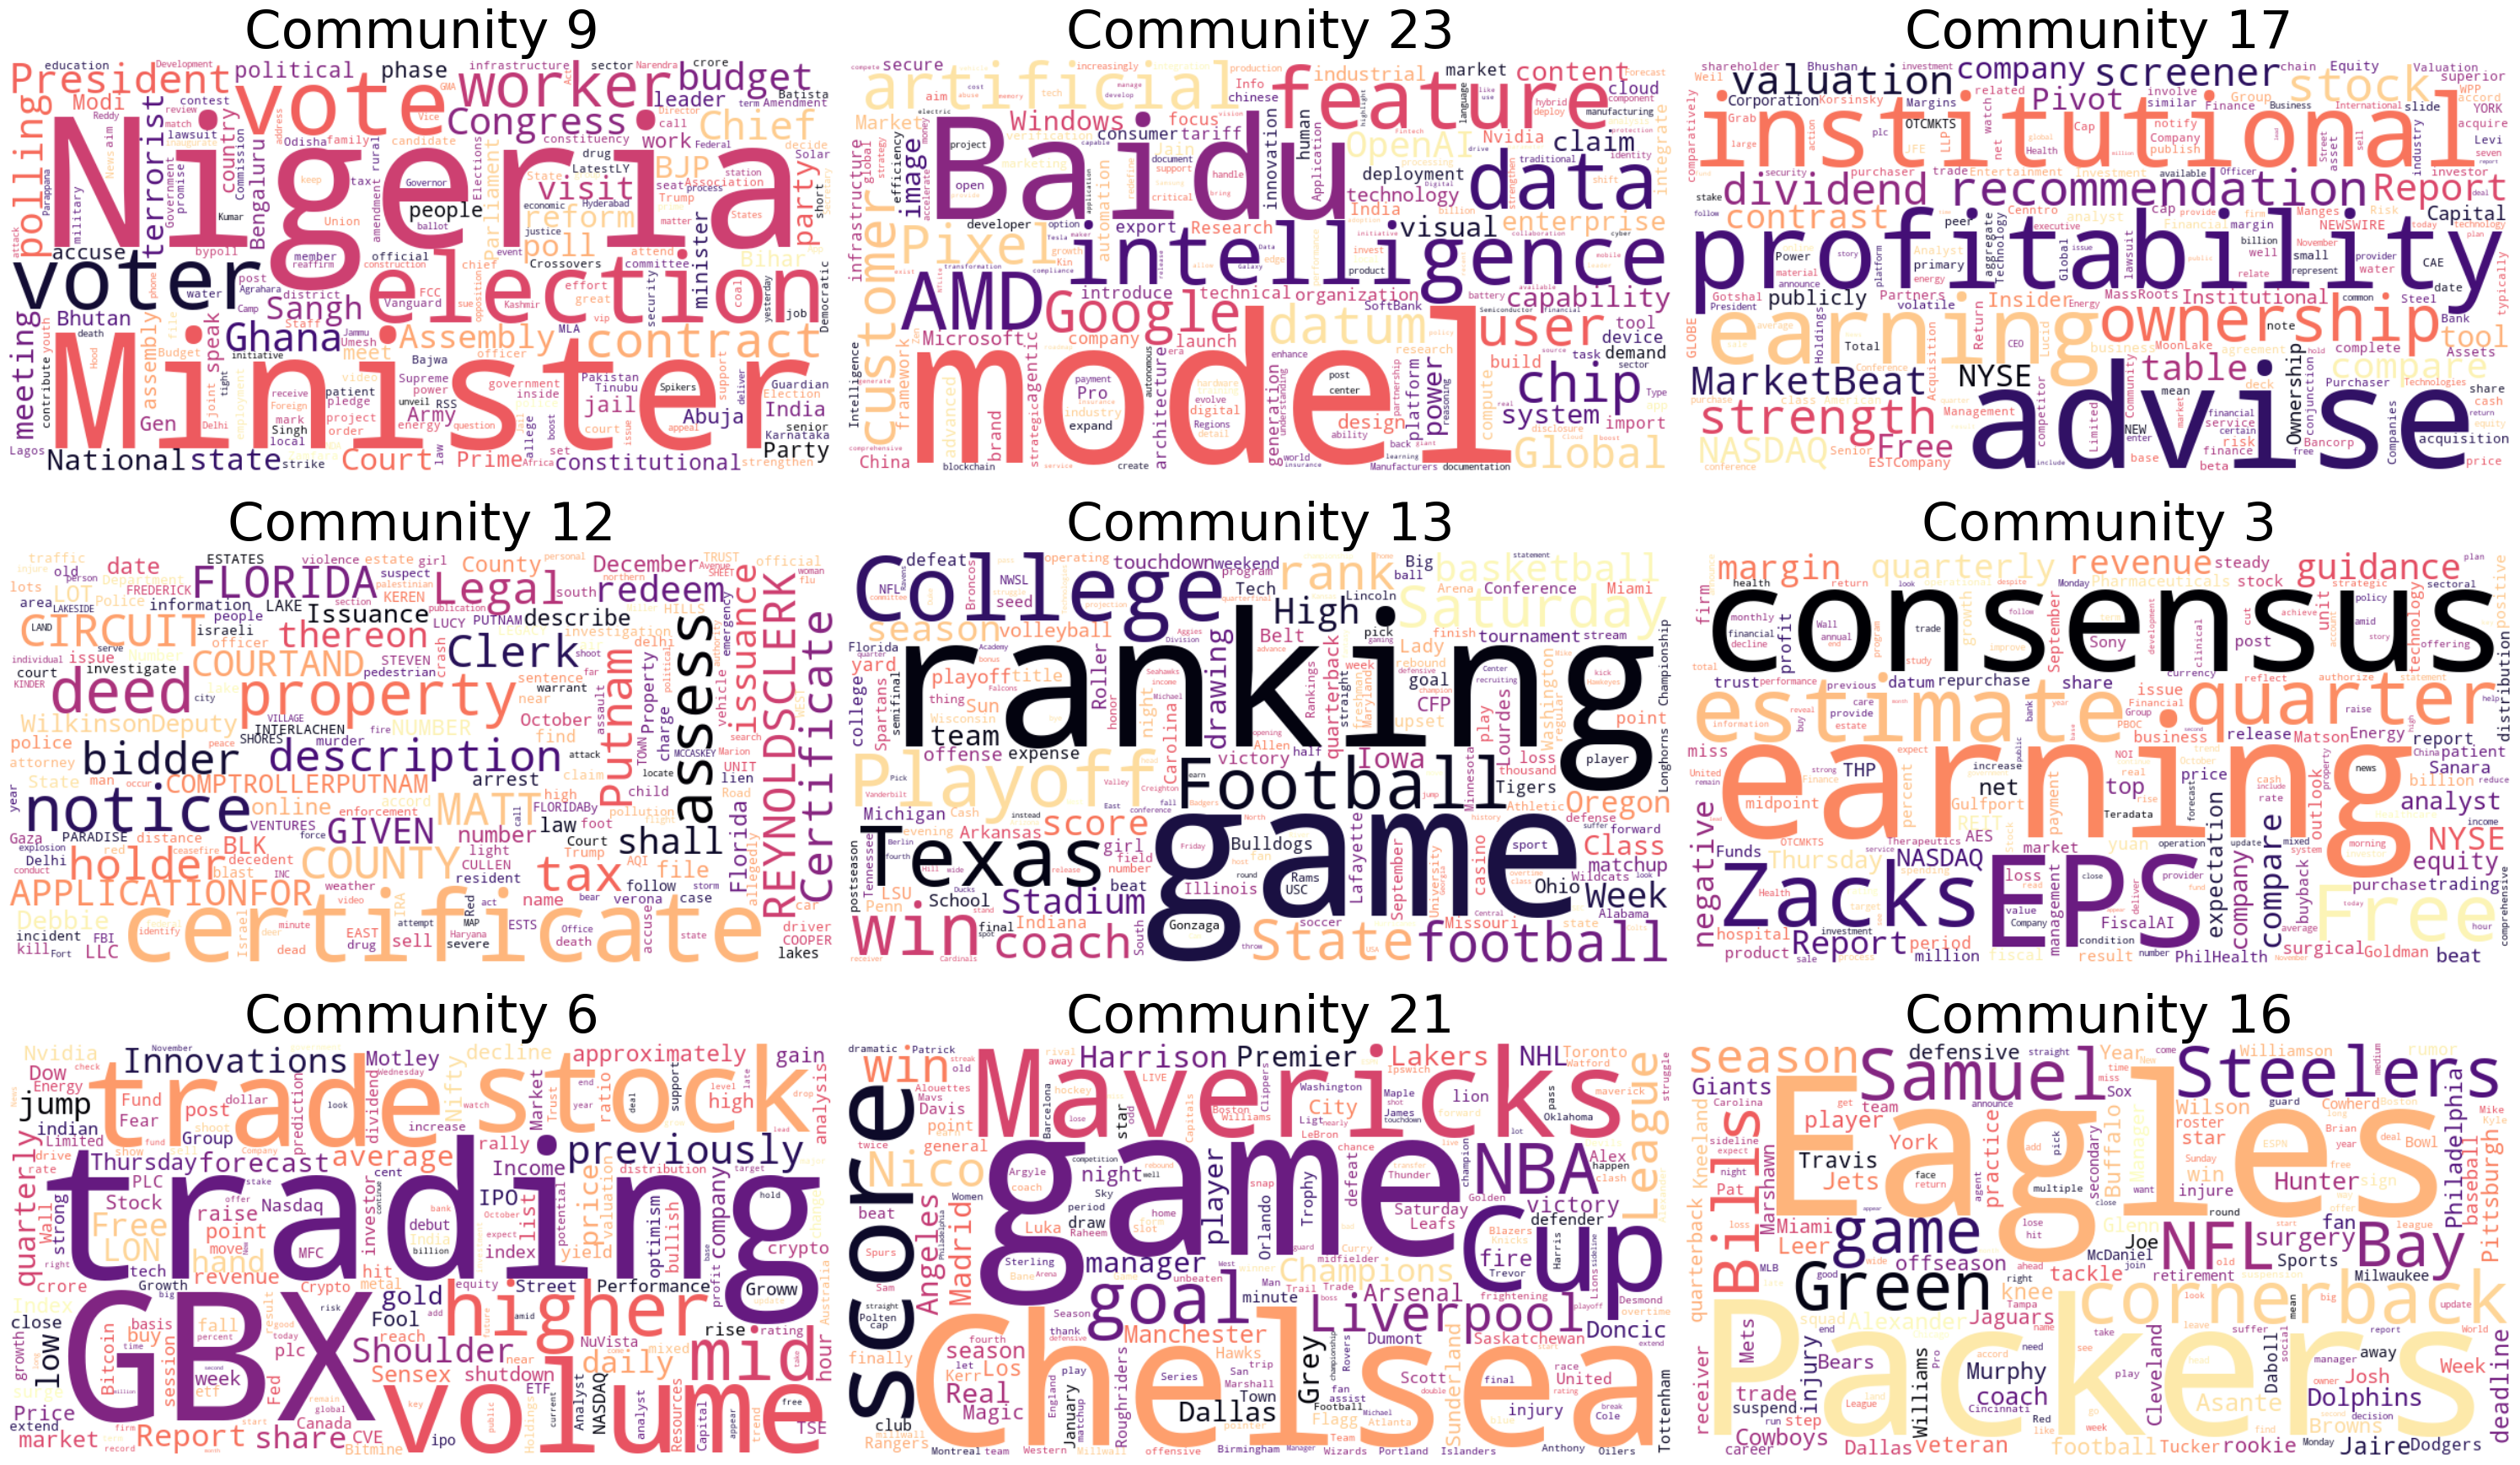

In [44]:
# ! The plotting only during with 9 communities due to subplots
fig, axes = plt.subplots(3,3, figsize=(30,18))
axes = axes.flatten()

for i, (comm, tfidf_dict)  in enumerate(TF_IDFs.items()):
    wc = wordcloud.WordCloud(
        width=800, 
        height=400,
        background_color="white", 
        colormap="magma", 
        collocations=False
    )
    wc.generate_from_frequencies(tfidf_dict)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {comm}", fontsize=45)

plt.tight_layout()
plt.show()

## **Statistical Tests**

In [62]:
df = nwdf.copy()
community_col = 'louvain_community'

def add_category_dummies(df, category_col='category', prefix='cat_'):
    df = df.copy()
    
    def to_list(x):
        if isinstance(x, list):
            return x
        if pd.isna(x):
            return []
        return [x]
    
    df[category_col] = df[category_col].apply(to_list)
    
    exploded = df[category_col].explode()
    dummies = pd.get_dummies(exploded, prefix=prefix).groupby(level=0).max()
    df = df.join(dummies)
    return df, dummies.columns.tolist()

df, category_dummy_cols = add_category_dummies(df, category_col='category', prefix='cat_')
df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)


all_attributes = [ 'press_freedom_current_rank', 'legal_framework_rank', 'sociocultural_context_rank', 
                  'safety_rank', 'political_context_rank', 'economic_context_rank', 'income_group', 
                  'income_rank',
                  'category', 'press_freedom_slope_of_ranks', 'press_freedom_mean_rank', 
                  'press_freedom_median_rank', 'press_freedom_variance', 'press_freedom_min_rank', 
                  'press_freedom_max_rank', 'sociocultural_context_score', 'legal_framework_score', 
                  'safety_score', 'economic_context_score', 'press_freedom_index_score', 
                  'political_context_score', 'corruption_latest_score', 'corruption_score_slope', 
                  'corruption_mean_score', 'corruption_median_score', 'corruption_score_variance',
                  'corruption_min_score', 'corruption_max_score', 'population', 
                  'gross_domestic_product_millions_usd', 'number_of_articles',
                  'articles_per_million_capita', 'gdp_per_capita_2024_international_dollars',
                  'inflation_2024_percent_change', 'consumer_price_index_in_2024_compared_to_2010', 
                  'median_age_2024', 'average_years_of_schooling_2023', 'description_sentiment_score', 
                  'title_sentiment_score', 'number_of_words_with_angry_sentiment_score', 'country',
                  'continent']

numeric_candidates = ['income_rank', 'press_freedom_current_rank', 'legal_framework_rank', 'sociocultural_context_rank',
                      'safety_rank', 'political_context_rank', 'economic_context_rank', 
                      'press_freedom_slope_of_ranks', 'press_freedom_mean_rank', 
                      'press_freedom_median_rank', 'press_freedom_variance', 'press_freedom_min_rank', 
                      'press_freedom_max_rank', 'sociocultural_context_score', 'legal_framework_score', 
                      'safety_score', 'economic_context_score', 'press_freedom_index_score', 
                      'political_context_score', 'corruption_latest_score', 'corruption_score_slope', 
                      'corruption_mean_score', 'corruption_median_score', 'corruption_score_variance', 
                      'corruption_min_score', 'corruption_max_score', 'population', 
                      'gross_domestic_product_millions_usd', 'number_of_articles', 
                      'articles_per_million_capita', 'gdp_per_capita_2024_international_dollars', 
                      'inflation_2024_percent_change', 'consumer_price_index_in_2024_compared_to_2010', 
                      'median_age_2024', 'average_years_of_schooling_2023']

ordinal_attributes = ['income_rank', 'press_freedom_current_rank', 'legal_framework_rank', 
                      'sociocultural_context_rank', 'safety_rank', 'political_context_rank', 
                      'economic_context_rank',]

nominal_attributes = ['louvain_community', 'country', 'continent', 'category', 'cat__business', 'cat__crime',
                      'cat__domestic','cat__education','cat__entertainment','cat__environment','cat__food',
                      'cat__health','cat__lifestyle','cat__other','cat__politics','cat__science',
                      'cat__sports','cat__technology','cat__top','cat__tourism','cat__world']

metric_attributes = ['press_freedom_slope_of_ranks', 'press_freedom_mean_rank', 
                     'press_freedom_median_rank', 'press_freedom_variance', 'press_freedom_min_rank', 
                     'press_freedom_max_rank', 'sociocultural_context_score', 'legal_framework_score', 
                     'safety_score', 'economic_context_score', 'press_freedom_index_score', 
                     'political_context_score', 'corruption_latest_score', 'corruption_score_slope', 
                     'corruption_mean_score', 'corruption_median_score', 'corruption_score_variance',
                     'corruption_min_score', 'corruption_max_score', 'population', 
                     'gross_domestic_product_millions_usd', 'number_of_articles',
                     'articles_per_million_capita', 'gdp_per_capita_2024_international_dollars',
                     'inflation_2024_percent_change', 'consumer_price_index_in_2024_compared_to_2010', 
                     'median_age_2024', 'average_years_of_schooling_2023', 'description_sentiment_score', 
                     'title_sentiment_score', 'anticipation_d', 'trust_d', 'joy_d', 'positive_d', 
                     'surprise_d', 'anger_d', 'disgust_d', 'negative_d', 'fear_d', 'sadness', 'joy', 
                     'positive', 'surprise', 'trust', 'anger', 'anticipation', 'disgust', 'negative', 
                     'fear', 'sadness']

numeric_cols = [c for c in numeric_candidates if c in df.columns]

categorical_attributes = ['income_group', 'country', 'continent']
categorical_cols = [c for c in categorical_attributes if c in df.columns]


def kruskal_by_community(df, community_col, numeric_cols, min_group_size=5):
    results = []

    for col in numeric_cols:
        if col not in df.columns:
            continue

        s = df[col]

        if isinstance(s, pd.DataFrame):
            print(f"Skipping {col}: It is a 2D column (DataFrame/MultiIndex).")
            continue

        s_num = pd.to_numeric(s, errors='coerce')

        sub = pd.DataFrame({community_col: df[community_col],col: s_num}).dropna()

        if sub.empty or sub[community_col].nunique() < 2:
            continue

        groups = []
        for g, gser in sub.groupby(community_col)[col]:
            if len(gser) >= min_group_size:
                arr = np.asarray(gser.values, dtype=float).ravel()
                if arr.ndim == 1 and len(arr) > 0:
                    groups.append(arr)

        if len(groups) < 2:
            continue

        H, p = stats.kruskal(*groups)
        H = float(np.asarray(H).ravel()[0])
        p = float(np.asarray(p).ravel()[0])

        n = sum(len(g) for g in groups)
        k = len(groups)
        eps2 = (H - k + 1) / (n - k) if n > k else np.nan

        results.append({'attribute': col, 'test': 'kruskal', 'H_statistic': H, 'p_value': p, 
                        'epsilon_squared': eps2, 'n_total': n, 'n_groups': k})

    if not results:
        return pd.DataFrame(columns=['attribute', 'test', 'H_statistic', 'p_value', 'epsilon_squared', 
                                     'n_total', 'n_groups'])

    df_res = pd.DataFrame(results)
    df_res['p_value'] = pd.to_numeric(df_res['p_value'], errors='coerce')
    return df_res.sort_values('p_value')

def chi2_by_community(df, community_col, cat_cols):
    results = []

    for col in cat_cols:
        if col not in df.columns:
            continue

        sub = df[[community_col, col]].dropna()

        if sub[community_col].nunique() < 2 or sub[col].nunique() < 2:
            continue

        contingency = pd.crosstab(sub[community_col], sub[col])
        if contingency.size == 0:
            continue

        chi2, p, dof, expected = stats.chi2_contingency(contingency)

        n = contingency.to_numpy().sum()
        r, c = contingency.shape
        denom = n * (min(r - 1, c - 1))
        cramers_v = np.sqrt(chi2 / denom) if denom > 0 else np.nan

        results.append({'attribute': col, 'test': 'chi2', 'chi2': chi2, 'dof': dof, 'p_value': p, 
                        'cramers_v': cramers_v, 'n_total': n, 'n_rows': r, 'n_cols': c})

    if not results:
        return pd.DataFrame(columns=['attribute', 'test', 'chi2', 'dof', 'p_value', 'cramers_v', 
                                     'n_total', 'n_rows', 'n_cols'])

    df_res = pd.DataFrame(results)
    df_res['p_value'] = pd.to_numeric(df_res['p_value'], errors='coerce')
    return df_res.sort_values('p_value')


kw_results = kruskal_by_community(df, community_col=community_col, numeric_cols=numeric_cols)
kw_small_effect = kw_results[kw_results['epsilon_squared'] < 0.06],
kw_moderate_effect = kw_results[(kw_results['epsilon_squared'] >= 0.06) & (kw_results['epsilon_squared'] < 0.14)]
kw_large_effect =  kw_results[kw_results['epsilon_squared'] >= 0.14]

chi2_cat_results = chi2_by_community(df, community_col=community_col, cat_cols=categorical_cols)

chi2_category_tag_results = chi2_by_community(df, community_col=community_col, 
                                              cat_cols=category_dummy_cols)
#cat_resulsts and category_tag_results
chi2_approx_none = chi2_cat_results[chi2_cat_results['cramers_v'] < 0.1], chi2_category_tag_results[chi2_category_tag_results['cramers_v'] < 0.1]
chi2_weak_assoc = chi2_cat_results[(chi2_cat_results['cramers_v'] >= 0.1) & (chi2_cat_results['cramers_v'] < 0.3)], chi2_category_tag_results[(chi2_category_tag_results['cramers_v'] >= 0.1) & (chi2_category_tag_results['cramers_v'] < 0.3)]
chi2_moderate_assoc = chi2_cat_results[(chi2_cat_results['cramers_v'] >= 0.3) & (chi2_cat_results['cramers_v'] < 0.5)], chi2_category_tag_results[(chi2_category_tag_results['cramers_v'] >= 0.3) & (chi2_category_tag_results['cramers_v'] < 0.5)]
chi2_strong_assoc = chi2_cat_results[chi2_cat_results['cramers_v'] >= 0.5], chi2_category_tag_results[chi2_category_tag_results['cramers_v'] >= 0.5]

print("Kruskal–Wallis (numerical variables):")
display(kw_results.sort_values('epsilon_squared', ascending=False))

print("\nChi² (income_group/country/continent):")
display(chi2_cat_results)

print("\nChi² (category-tags from 'category'):")
display(chi2_category_tag_results.sort_values('cramers_v', ascending=False))


<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bella\AppData\Local\Temp\ipykernel_29548\1836811706.py:22: SyntaxWarning: invalid escape sequence '\d'
  df['income_rank'] = df['income_group'].str.extract('(\d+)').astype(float)


Kruskal–Wallis (numerical variables):


attribute     test  H_statistic  \
33                                median_age_2024  kruskal   540.231336   
0                                     income_rank  kruskal  1025.969967   
20                         corruption_score_slope  kruskal   927.674734   
27            gross_domestic_product_millions_usd  kruskal   900.474539   
28                             number_of_articles  kruskal   897.017189   
32  consumer_price_index_in_2024_compared_to_2010  kruskal   413.294647   
31                  inflation_2024_percent_change  kruskal   375.926798   
30      gdp_per_capita_2024_international_dollars  kruskal   380.430861   
23                      corruption_score_variance  kruskal   681.862043   
34                average_years_of_schooling_2023  kruskal   344.286315   
29                    articles_per_million_capita  kruskal   606.397441   
11                         press_freedom_min_rank  kruskal   566.687327   
2                            legal_framework_rank  kruskal   547.587778   
14                          legal_framework_score  kruskal   547.587778   
22                        corruption_median_score  kruskal   531.277631   
21                          corruption_mean_score  kruskal   525.730628   
25                           corruption_max_score  kruskal   525.663012   
24                           corruption_min_score  kruskal   496.157465   
19                        corruption_latest_score  kruskal   494.116720   
12                         press_freedom_max_rank  kruskal   449.251290   
10                         press_freedom_variance  kruskal   434.180018   
16                         economic_context_score  kruskal   399.952880   
6                           economic_context_rank  kruskal   399.952880   
8                         press_freedom_mean_rank  kruskal   390.394788   
18                        political_context_score  kruskal   390.252978   
5                          political_context_rank  kruskal   390.252978   
17                      press_freedom_index_score  kruskal   384.870261   
1                      press_freedom_current_rank  kruskal   384.870261   
9                       press_freedom_median_rank  kruskal   382.466478   
4                                     safety_rank  kruskal   309.672442   
15                                   safety_score  kruskal   309.672442   
13                    sociocultural_context_score  kruskal   234.568673   
3                      sociocultural_context_rank  kruskal   234.568673   
7                    press_freedom_slope_of_ranks  kruskal   212.729314   
26                                     population  kruskal   205.150721   

          p_value  epsilon_squared  n_total  n_groups  
33   1.455977e-99         0.233830     2236        24  
0   7.367478e-199         0.229701     4377        28  
20  4.637317e-178         0.204559     4431        28  
27  2.579421e-172         0.200845     4377        28  
28  1.384970e-171         0.200050     4377        28  
32   3.244327e-73         0.182125     2167        24  
31   1.568910e-65         0.164535     2169        24  
30   1.868803e-66         0.163210     2214        24  
23  2.381819e-126         0.148731     4431        28  
34   4.652146e-59         0.145247     2236        24  
29  1.346317e-110         0.133225     4377        28  
11  2.430619e-102         0.122656     4428        28  
2    2.226914e-98         0.118315     4428        28  
14   2.226914e-98         0.118315     4428        28  
22   5.319705e-95         0.114530     4431        28  
21   7.475670e-94         0.113271     4431        28  
25   7.720355e-94         0.113255     4431        28  
24   9.602125e-88         0.106554     4431        28  
19   2.530632e-87         0.106091     4431        28  
12   4.277367e-78         0.095966     4428        28  
10   5.242014e-75         0.092541     4428        28  
16   5.108774e-68         0.084762     4428        28  
6    5.108774e-68         0.084762     4428        


Chi² (income_group/country/continent):


attribute  test         chi2   dof        p_value  cramers_v  n_total  \
1       country  chi2  6899.995333  1914   0.000000e+00   0.231335     4446   
2     continent  chi2  1970.104401   145   0.000000e+00   0.297965     4438   
0  income_group  chi2  1183.128679   116  3.366332e-176   0.259747     4384   

   n_rows  n_cols  
1      30      67  
2      30       6  
0      30       5


Chi² (category-tags from 'category'):


attribute  test         chi2  dof        p_value  cramers_v  \
12         cat__sports  chi2  3096.268258   29   0.000000e+00   0.834516   
0        cat__business  chi2  1866.927152   29   0.000000e+00   0.648006   
1           cat__crime  chi2  1223.554599   29  3.747245e-239   0.524598   
4   cat__entertainment  chi2  1179.037305   29  1.055833e-229   0.514967   
13     cat__technology  chi2  1088.825177   29  1.403020e-210   0.494874   
10       cat__politics  chi2   918.574530   29  1.323349e-174   0.454540   
15        cat__tourism  chi2   881.737347   29  7.609389e-167   0.445333   
14            cat__top  chi2   739.034742   29  6.860656e-137   0.407707   
8       cat__lifestyle  chi2   660.127681   29  2.045402e-120   0.385327   
7          cat__health  chi2   413.323497   29   1.477987e-69   0.304902   
9           cat__other  chi2   304.725154   29   9.444022e-48   0.261800   
5     cat__environment  chi2   272.215042   29   2.388790e-41   0.247441   
11        cat__science  chi2   127.647923   29   2.434591e-14   0.169442   
16          cat__world  chi2   113.490552   29   6.101859e-12   0.159770   
3       cat__education  chi2   101.557757   29   5.502516e-10   0.151137   
6            cat__food  chi2    73.576394   29   9.677052e-06   0.128643   
2        cat__domestic  chi2    54.591279   29   2.764448e-03   0.110809   

    n_total  n_rows  n_cols  
12     4446      30       2  
0      4446      30       2  
1      4446      30       2  
4      4446      30       2  
13     4446      30       2  
10     4446      30       2  
15     4446      30       2  
14     4446      30       2  
8      4446      30       2  
7      4446      30       2  
9      4446      30       2  
5      4446      30       2  
11     4446      30       2  
16     4446      30       2  
3      4446      30       2  
6      4446      30       2  
2      4446      30       2

### Explore correlation betwen Louvian communities and emotions/sentiments

In [63]:
columns_description = ['anticipation_d', 'trust_d', 'joy_d', 'surprise_d', 'anger_d', 'disgust_d', 'fear_d', 'sadness_d']
columns_title = [ 'joy', 'surprise', 'trust', 'anger', 'anticipation', 'disgust', 'fear', 'sadness']

nwdf["title_length"] = nwdf["wl_title"].str.len()
nwdf["description_length"] = nwdf["wl_description"].str.len()

In [64]:
# Normalize counts of emotional words
for col in columns_description:
    nwdf[col+'_norm'] = nwdf[col]/nwdf["description_length"]

for col in columns_title:
    nwdf[col+'_norm'] = nwdf[col]/nwdf["description_length"]

In [68]:
columns = ['description_sentiment_score', 'title_sentiment_score',
       'anticipation_d_norm', 'trust_d_norm',
       'joy_d_norm', 'surprise_d_norm', 'anger_d_norm', 'disgust_d_norm',
       'fear_d_norm', 'sadness_d_norm', 'joy_norm', 'surprise_norm',
       'trust_norm', 'anger_norm', 'anticipation_norm', 'disgust_norm',
       'fear_norm', 'sadness_norm']

In [69]:
kw_results_emotions = kruskal_by_community(nwdf, community_col='louvain_community', numeric_cols=columns)
kw_results_emotions

attribute     test  H_statistic        p_value  \
0   description_sentiment_score  kruskal   825.704644  1.507071e-156   
1         title_sentiment_score  kruskal   622.812788  5.118160e-114   
8                   fear_d_norm  kruskal   333.908299   1.533183e-57   
4                    joy_d_norm  kruskal   243.852374   2.433112e-39   
2           anticipation_d_norm  kruskal   202.625796   3.482379e-31   
14            anticipation_norm  kruskal   158.241600   3.594990e-22   
6                  anger_d_norm  kruskal   134.278930   6.111304e-19   
9                sadness_d_norm  kruskal   118.712348   2.987189e-15   
5               surprise_d_norm  kruskal   113.457052   1.116168e-14   
3                  trust_d_norm  kruskal   114.897621   7.788255e-14   
16                    fear_norm  kruskal   107.541113   1.306218e-13   
10                     joy_norm  kruskal   103.875887   1.346697e-12   
12                   trust_norm  kruskal    93.709876   1.680881e-10   
13                   anger_norm  kruskal    82.980267   1.038276e-08   
17                 sadness_norm  kruskal    66.625248   1.208505e-06   
7                disgust_d_norm  kruskal    65.588270   1.758651e-06   
11                surprise_norm  kruskal    65.623639   3.169606e-06   
15                 disgust_norm  kruskal    44.057069   5.661658e-04   

    epsilon_squared  n_total  n_groups  
0          0.181235     4435        28  
1          0.135720     4418        28  
8          0.158409     1992        23  
4          0.123595     1818        23  
2          0.072308     2521        23  
14         0.090463     1519        24  
6          0.075134     1542        21  
9          0.064691     1518        23  
5          0.070686     1330        22  
3          0.030390     3016        25  
16         0.068143     1292        22  
10         0.083462     1004        23  
12         0.041448     1730        24  
13         0.060525     1015        24  
17         0.052443      892        22  
7          0.052643      869        22  
11         0.052119      860        23  
15         0.056523      480        19

### Explore correlation between category-based communities and emotions

In [50]:
kw_results_cat = kruskal_by_community(nwdf, community_col='category_community', numeric_cols=columns)
kw_results_cat

attribute     test  H_statistic        p_value  \
0   description_sentiment_score  kruskal   689.814613  2.753157e-137   
1         title_sentiment_score  kruskal   536.792893  9.171213e-105   
8                   fear_d_norm  kruskal   318.344984   1.748712e-59   
4                    joy_d_norm  kruskal   177.892662   6.321946e-30   
9                sadness_d_norm  kruskal   139.575257   8.617456e-23   
6                  anger_d_norm  kruskal   133.681006   1.272365e-21   
16                    fear_norm  kruskal   117.652656   5.851927e-19   
2           anticipation_d_norm  kruskal    99.869396   1.381223e-14   
17                 sadness_norm  kruskal    93.255663   9.176059e-14   
5               surprise_d_norm  kruskal    93.193752   9.427793e-14   
13                   anger_norm  kruskal    87.251544   1.677231e-13   
7                disgust_d_norm  kruskal    88.889072   2.278499e-13   
14            anticipation_norm  kruskal    88.556976   7.103661e-13   
12                   trust_norm  kruskal    85.493089   6.819500e-12   
10                     joy_norm  kruskal    78.564456   2.052833e-11   
11                surprise_norm  kruskal    74.891587   2.477277e-10   
15                 disgust_norm  kruskal    46.422190   5.867408e-06   
3                  trust_d_norm  kruskal    31.663402   7.152386e-03   

    epsilon_squared  n_total  n_groups  
0          0.152466     4442        16  
1          0.118347     4425        16  
8          0.153943     1992        15  
4          0.089946     1827        16  
9          0.083661     1516        15  
6          0.078223     1545        15  
16         0.081505     1298        14  
2          0.033718     2533        16  
17         0.089554      900        15  
5          0.060132     1332        15  
13         0.075327     1012        13  
7          0.089176      865        14  
14         0.049213     1530        15  
12         0.040747     1746        16  
10         0.065828     1010        14  
11         0.071553      866        15  
15         0.072316      489        13  
3          0.005536     3026        16

### Sentiment scores in subset of communities

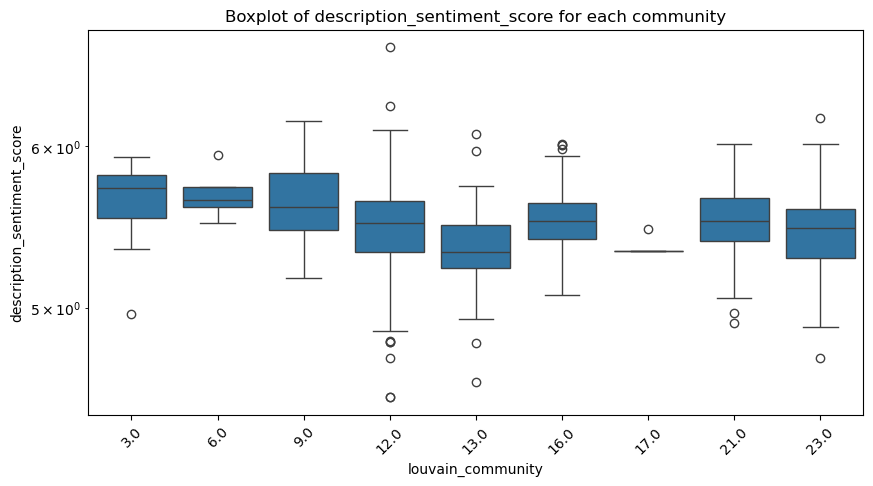

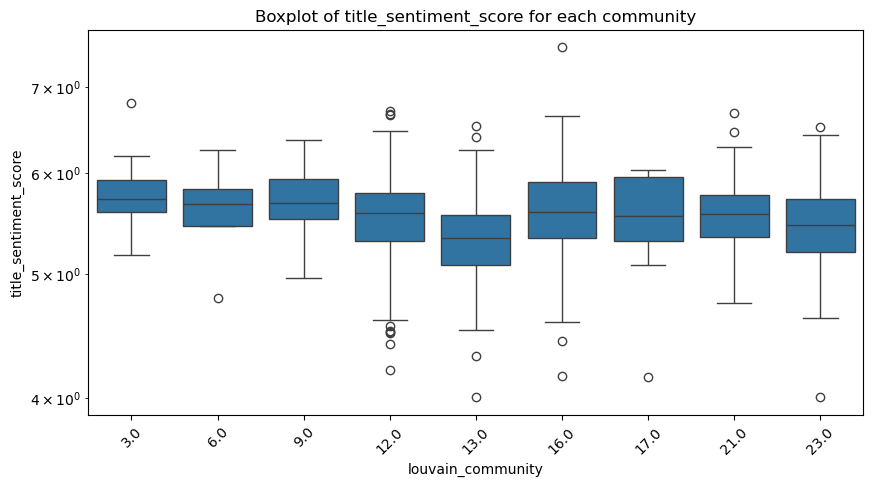

In [73]:
# Printing a bunch of boxplots
subset_columns = ['description_sentiment_score', 'title_sentiment_score']
for col in subset_columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=nwdf[nwdf.louvain_community.isin(interest_lc_ids)], x="louvain_community", y=col, ax=ax)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale('log')
    plt.title(f"Boxplot of {col} for each community")
    plt.show()

### Histograms of communities and emotional words

In [88]:
emotions_cols = ['anticipation_d_norm', 'trust_d_norm',
       'joy_d_norm', 'surprise_d_norm', 'anger_d_norm', 'disgust_d_norm',
       'fear_d_norm', 'sadness_d_norm']
# emotions_cols = ['joy_norm', 'surprise_norm',
#        'trust_norm', 'anger_norm', 'anticipation_norm', 'disgust_norm',
#        'fear_norm', 'sadness_norm']

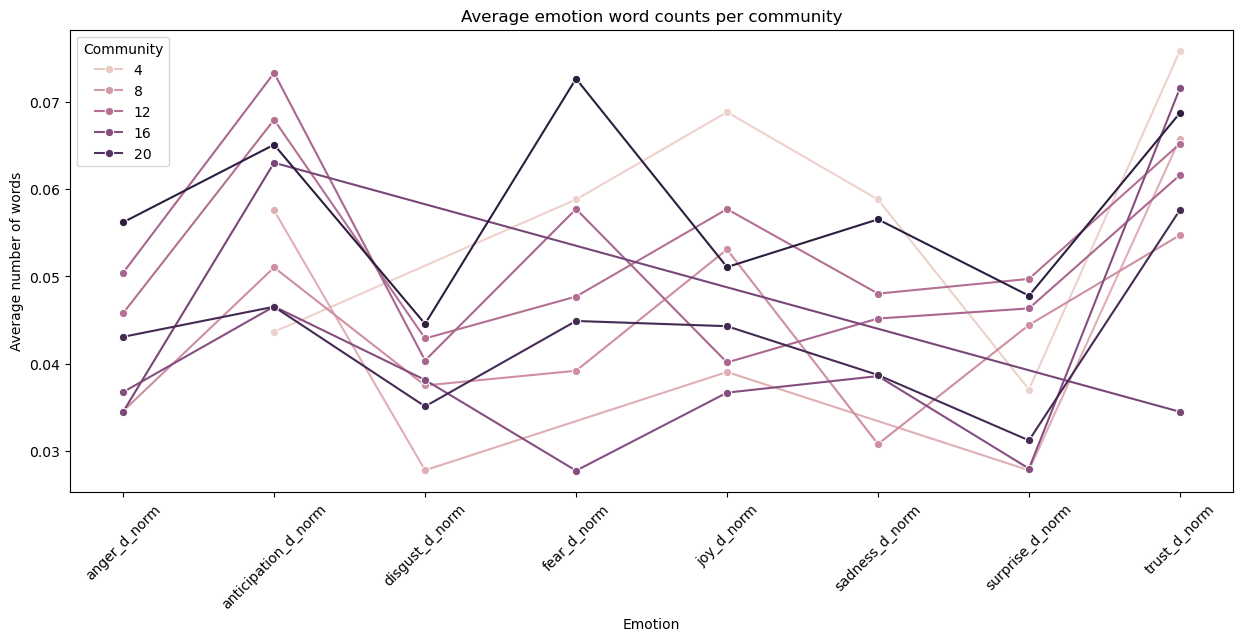

In [123]:
# Gather all counts in one column
emotion_df = (nwdf[nwdf.louvain_community.isin(interest_lc_ids)].melt(
        id_vars="louvain_community",
        value_vars=emotions_cols,
        var_name="emotion",
        value_name="count"
    )
)

# Then calculate an average score of each emotion for each community
avg_df = (emotion_df.groupby(["louvain_community", "emotion"], as_index=False).agg(avg_count=("count", "mean")))

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=avg_df,
    x="emotion",
    y="avg_count",
    hue="louvain_community",
    marker="o",
    ax=ax
)

ax.set_xlabel("Emotion")
ax.set_ylabel("Average number of words")
ax.set_title("Average emotion word counts per community")
ax.tick_params(axis="x", labelrotation=45)
ax.legend(title="Community")

plt.show()